# Introducción
A continuación se presentará el trabajo final de la asignatura Inteligencia Artificial, durante el desarrollo de las temáticas de la asignatura aprendimos acerca de los diversos métodos para aplicar la inteligencia artificial y la forma en la que estos se clasifican.
A lo largo de la última sección del curso nos centramos específicamente en el machine learning, entiendase como machine learning a "La capacidad de predecir el futuro, por ejemplo, el peso de un vaso que vamos a levantar o la reacción de los demás a nuestros actos, en base a los patrones almacenados en la memoria." según Jeff Hawkins en su libro sobre la inteligencia artificial (publicado en 2004).
Dicha rama de la programación se divide en 3 grupos de estudio:

* Aprendizaje supervisado.
* Aprendizaje no supervisado.
* Aprendizaje por Refuerzo.

Y durante el desarrollo de la sección nos centraremos en el aprendizaje supervisado, aplicando conocidos métodos de aprendizaje supervisado como lo son:

* Árboles de decisión.
* Random Forest.
* Redes neuronales.

Para ello seguiremos los pasos para aplicar los métodos y las recomendaciones vistas en clase.

# Desarrollo
Antes de comenzar, consideramos necesario explicar los métodos y bases teóricas, sirviendo a manera de guía a lo largo de la implementación práctica de los métodos anteriormente mencionados.

## Bases teóricas
Como mencionamos con anterioridad estudiaremos métodos de aprendizaje supervisado, pero resulta necesario comprenderlo más a fondo para mejorar la comprensión del trabajo.

### Aprendizaje supervisado
El aprendizaje supervisado cuenta con una estrategia basada en funciones y predicciones a partir de estas mismas, estos métodos intentan entrenar el modelo con un conjunto de datos de entrenamientos, los cuales cuentan tanto con variables independientes como con variables dependientes, y se basan en identificar las variables independientes y por medio de una serie de mecanismos identificar una función que logre retornar la variable dependiente correspondiente a los datos.
Podemos ver una explicación más gráfica en el siguiente diagrama.

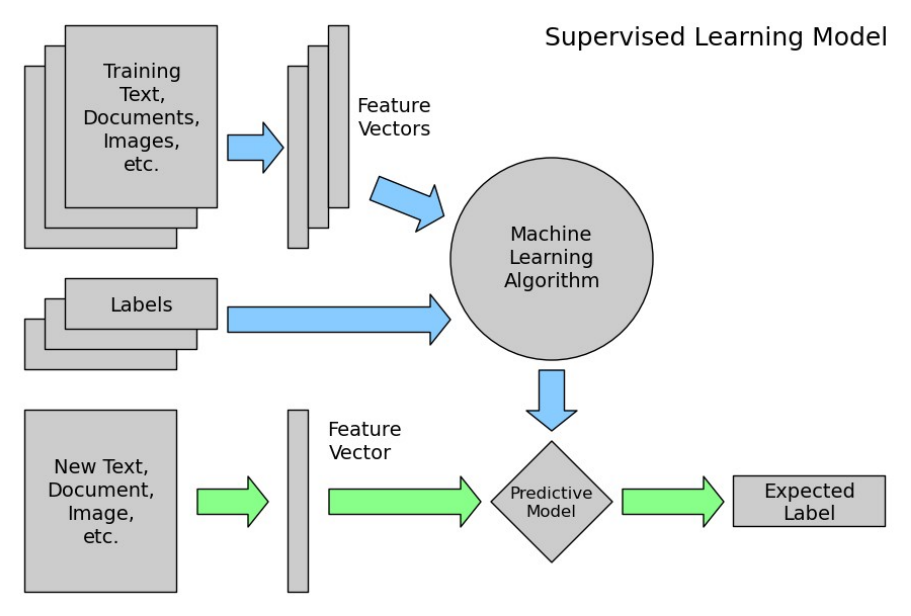

### Proceso de aplicación de machine learning
El machine learning, al ser un campo con tantos años de estudio, cuenta con un debido proceso para lograr darle solución a un problema, este proceso cuenta con una serie de pasos, los cuales aplicaremos a continuación a manera de guia, permitiendonos solucionar el problema planteado de una manera organizada y sencilla, dichos pasos son:

* Formular la pregunta.
* Obtener y entender los datos.
* Limpiar los datos.
* Seleccionar el o los modelos.
* Ajustar y evaluar los modelos.
* Utilizar el modelo y mostrar los resultados.

## Descripción del problema
El problema que trataremos a continuacion es un clasificador de texto, el cual tiene como clases dos idiomas, dichos idiomas son:

* Ingles: El idioma inglés es una lengua germánica occidental perteneciente a la familia de lenguas indoeuropeas, que surgió en los reinos anglosajones de Inglaterra. Hoy en día el inglés es tanto el idioma más hablado en el mundo, así como como el tercer idioma nativo más hablado, después del chino mandarín y el español.
* Holandes: El idioma neerlandés es un idioma que pertenece a la familia germánica, que a su vez es miembro de la familia indoeuropea. En países de habla hispana es comúnmente conocido como holandés, término hasta cierto punto aceptado por la RAE, aunque sea el nombre de uno de los dialectos del neerlandés. Forma parte del grupo germánico occidental, relacionado con el bajo alemán. Es la lengua materna de más de 25 000 000 de personas en el mundo y la tercera lengua germánica con más hablantes nativos, después del inglés y el alemán.

Podemos ver que ambos idiomas forman parte de la familia de lenguas indoeuropeas y cuentan con una estrecha relacion, sin embargo cabe destacar que el holandes es mucho más cercano al alemán que al inglés. 

Continuando con el trabajo podemos decir que para el desarrollo del problema contaremos con un registro de datos obtenidos de kaggle y tomados a su vez de articulos aleatorios de wikipedia pertenecientes a los registros de ambos idiomas, compilados en el archivo llamado train_new.txt, este cuenta con dos columnas, en la cual podemos ver un texto en ingles o holandes y una palabra "en" o "nl" la cual representa el idioma en el que está escrito dicho texto, estas columnas se encuentran separadas por el caracter | y en el archivo cuenta con un poco más de 1000 ejemplos de alrededor de 15 segmentos de palabras.

A lo largo del trabajo se pretende analizar las oraciones de los diferentes idiomas tomadas de nuestra fuente, con el objetivo de clasificar un subconjunto de prueba a partir del entrenamiento recibido empleando otro subconjunto de entrenamiento logrando así clasificar el texto proporcionado entre las dos clases (ingles o holandes), utilizando los métodos anteriormente mencionados.
En la siguiente sección abordaremos con mayor profundidad el conjunto de datos y el significado de estos mismos.

Finalizando así con la obtención de las mejores configuraciones para cada método e identificando el método más eficiente para llevar a cabo la tarea de clasificación.

### Objetivos generales:

* Aplicar procesar el conjunto de datos.
* Implementar los modelos de aprendizaje de máquina.
* Realizar análisis y evaluar los resultados de los métodos.

### objetivos específicos:

* Darle formato al conjunto de datos en una estructura computacional.
* Eliminar los caracteres especiales y numéricos.
* Eliminar las palabras innecesarias (éstas pueden ser palabras monosílabas, stopwords o palabras repetidas en ambos idiomas).
* Implementar funciones que nos faciliten el procesamiento de los datos en los modelos.
* Implementar y analizar los resultados de la implementación del modelo de árboles de decisión.
* Implementar y analizar los resultados de la implementación del modelo de bosque random.
* Implementar y analizar los resultados de la implementación del modelo de redes neuronales.
* Implementar y analizar los resultados de la implementación del modelo de redes neuronales profundas.
* Analizar los resultados de las implementaciones y llevar a cabo una conclusión.

## Descripción de variables
El conjunto de datos tomado de Kaggle es un dataset que está conformado por dos columnas la primera columna se llama "Language" y la segunda "Text".

* Variable objetivo Y: corresponde a la columna 'Language' del DataFrame df. Esta columna contiene la etiqueta del lenguaje ('en' o 'nl') asociada a cada texto.
* Variable predictora X: corresponde a la columna 'Text' del DataFrame df. Esta columna contiene el texto recopilado de los artículos de Wikipedia.

## implementación
A continuación se llevará a cabo la solución del problema abordando los procedimientos prácticos desde las bases teóricas vistos en la subsección de **Proceso de aplicación de machine learning** ubicado en la sección de **Bases teóricas**

### Formular la pregunta.
¿Cuál es el lenguaje correspondiente al texto ingresado (inglés o español)?

### Obtener y entender los datos:
Importando las librerías:


In [328]:
# Tratamiento de datos
import time
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import cosine
from unidecode import unidecode
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold

In [329]:
# Gráficos
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from wordcloud import WordCloud

In [330]:
# Preprocesado y modelado
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 

In [331]:
# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Lectura del archivo

In [332]:
# Ruta del archivo CSV en Google Drive
rt_reviews = "train_new.txt"

In [333]:
# Leer el archivo CSV en un DataFrame
df = pd.read_csv(rt_reviews, encoding='ISO-8859-1', sep="|")
df.columns = ["Language", "Text"]

In [334]:
# Verificar que los datos se hayan cargado correctamente
print(df.head())

  Language                                               Text
0       en  and Africa in permission winners,[25] of in ye...
1       en  President tournament wearing presenting were m...
2       en  The the are 'The thirty-eight reference as Ell...
3       en  a The Rugby In and Warrant head 'The Webb and ...
4       en  an high - The game engraved Crown Football two...


### Limpiar los datos:
A partir de este punto buscaremos la manera de limpiar los datos de una forma que sea más fácil procesarlos para el modelo, para ello limpiaremos la cadena de texto correspondiente a la columna "text" del Dataframe df, eliminando los caracteres especiales, números y convirtiendo la cadena a minúsculas.
además de hacer dos pruebas con el objetivo de optimizar el rendimiento de los modelos.


Primera prueba:
Es bien sabido que las stopwords, también conocidas como palabras vacías, son una parte importante de un lenguaje, ya que están conformadas por preposiciones, pronombres, conectores y demás recursos lingüísticos.
Es por ello que nos enfrentamos a una difícil decisión, la cual podemos afrontar a partir de dos políticas:

* La primera política sería no eliminar las stopwords debido a que estas son un factor importante para determinar el lenguaje al que pertenece un texto, sin embargo esto podría representar un esfuerzo computacional mayor el cual no justificaría la poca precisión obtenida.
* La segunda política sería eliminar las stopwords debido a que representan un gran porcentaje del total de palabras, aunque esto podría afectar la precisión del modelo.

Para dar solución a dicho problema decidimos evaluar ambas políticas al entrenar y probar un modelo con las mismas variables y una entrada de texto diferente (con stopwords y sin stopwords).


Preparación de los datos para probar las políticas

In [335]:
#definiendo la funcion para eliminar stopwords en ingles
def remove_posE(tokens):
    # Obtener la lista de stopwords (incluye preposiciones) en inglés
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    pronouns = set()
    tagged_words = pos_tag(stopwords)
    for word, tag in tagged_words:
        if tag.startswith('PRP'):
            pronouns.add(word)
    
    tagged_tokens = pos_tag(tokens)
    tokens_without_pos = [token[0] for token in tagged_tokens if token[0] not in stopwords and token[0] not in pronouns]
    
    return tokens_without_pos

In [336]:
#definiendo la funcion para eliminar stopwords en holandes
def remove_posH(tokens):
    # Obtener la lista de stopwords (incluye preposiciones) en holandes
    stopwords = set(nltk.corpus.stopwords.words('dutch'))
    
    pronouns = set()
    tagged_words = pos_tag(stopwords)
    for word, tag in tagged_words:
        if tag.startswith('PRP'):
            pronouns.add(word)
    
    tagged_tokens = pos_tag(tokens)
    tokens_without_pos = [token[0] for token in tagged_tokens if token[0] not in stopwords and token[0] not in pronouns]
    
    return tokens_without_pos

In [337]:
#limpiando los datos
def limpiar_tokenizar(stopwords,lang,texto):
    # Crear instancia del lematizador
    lemmatizer = WordNetLemmatizer()

    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\.\\/\\:\\;\\<\\<<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex, ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de diéresis
    nuevo_texto = unidecode(nuevo_texto)
    # Eliminación de fracciones
    nuevo_texto = re.sub("\d+/\d+", ' ', nuevo_texto)
    # Eliminación de fechas
    nuevo_texto = re.sub("\d{1,2}/\d{1,2}/\d{2,4}", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Lematización
    nuevo_texto = [lemmatizer.lemmatize(token) for token in nuevo_texto]
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    if(stopwords):
        # Eliminar preposiciones, pronombres y stopWords
        if(lang=="en"):
            nuevo_texto = remove_posE(nuevo_texto)
        else:
            nuevo_texto = remove_posH(nuevo_texto)
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if token.isalnum()]
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token.lower() for token in nuevo_texto ]
    return nuevo_texto

In [338]:
dfCopy = df.copy()
#guardando los datos con stopwords
df['texto_tokenizado'] = df.apply(
    lambda x: limpiar_tokenizar(False,x[0],x[1]), axis=1)
df.to_csv(
    'resultadoTokeniz.csv', index=False)

textFinal = df.explode(column='texto_tokenizado')
textFinal = textFinal.drop(columns='Text')
textFinal = textFinal.rename(columns={'texto_tokenizado': 'token'})


#guardando los datos con stopwords
dfCopy['texto_tokenizado'] = dfCopy.apply(
    lambda x: limpiar_tokenizar(True,x[0],x[1]), axis=1)
dfCopy.to_csv(
    'resultadoTokenizCopy.csv', index=False)

textFinalCopy = dfCopy.explode(column='texto_tokenizado')
textFinalCopy = textFinalCopy.drop(columns='Text')
textFinalCopy = textFinalCopy.rename(columns={'texto_tokenizado': 'token'})
palabrasEn = set(textFinal[textFinal.Language == 'en']['token'])
palabrasNl = set(textFinal[textFinal.Language == 'nl']['token'])

print(f"Palabras en Ingles: {len(palabrasEn)}, Palabras en Holandes: {len(palabrasEn)}, comunes entre Ingles y Holandes: {len(palabrasEn.intersection(palabrasNl))}")

Palabras en Ingles: 2626, Palabras en Holandes: 2626, comunes entre Ingles y Holandes: 164


Realización de pruebas con las dos políticas:

In [339]:
def to_array(x):
    item=x[2]
    item=item.replace("'", "")
    item=  item.strip('][').split(', ')
    return item
#conjunto con stopwords
ruta_archivo = r'./resultadoTokeniz.csv'
# Leer el archivo CSV
df = pd.read_csv(ruta_archivo, nrows=100000)


#conjunto sin stopwords
ruta_archivoCopy = r'./resultadoTokenizCopy.csv'

# Leer el archivo CSV
dfCopy = pd.read_csv(ruta_archivo, nrows=100000)

#conjunto con stopwords
datos_X = df['texto_tokenizado']
datos_y = df['Language']

print(datos_X.unique())
print(datos_y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size=0.80,
    random_state=42
)

#conjuntos sin stopwords
datos_XCopy = dfCopy['texto_tokenizado']
datos_yCopy = dfCopy['Language']

print(datos_XCopy.unique())
print(datos_yCopy.unique())

X_trainCopy, X_testCopy, y_trainCopy, y_testCopy = train_test_split(
    datos_XCopy,
    datos_yCopy,
    test_size=0.80,
    random_state=42
)

# Crear una instancia del vectorizador para el conjunto con stopwords
vectorizer = CountVectorizer()


# Ajustar el vectorizador con los datos de entrenamiento del conjunto con stopwords
Xtrain = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba utilizando el vectorizador ajustado
Xtest = vectorizer.transform(X_test)

# Ajustar el vectorizador con los datos de entrenamiento del conjunto sin stopwords
XtrainCopy = vectorizer.fit_transform(X_trainCopy)

# Transformar los datos de prueba utilizando el vectorizador ajustado
XtestCopy = vectorizer.transform(X_testCopy)

def cuasiConstantes(Xtrain, Xtest, threshold=0.02):
    # Crear el objeto VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)

    # Aplicar la eliminación de características cuasi-constantes en la matriz tf-idf de entrenamiento
    xtrain = selector.fit_transform(Xtrain)

    # Obtener los índices de las características seleccionadas
    selected_feature_indices = selector.get_support(indices=True)

    # Filtrar la matriz tf-idf de prueba utilizando los índices de características seleccionadas
    xtest = selector.transform(Xtest)

    num_selected_features = xtrain.shape[1]
    print("Número de características seleccionadas:", num_selected_features)

    return xtrain, xtest, selected_feature_indices

xtrain, xtest, selected_feature_indices=cuasiConstantes(Xtrain, Xtest)
xtrainCopy, xtestCopy, selected_feature_indicesCopy=cuasiConstantes(XtrainCopy, XtestCopy)


["['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test']"
 "['president', 'tournament', 'wearing', 'presenting', 'were', 'met', 'africa', 'series', 'the', 'resumption', 'rugby', 'the', 'opening', 'match']"
 "['the', 'the', 'are', 'the', 'reference', 'elli', 'garrard', 'in', 'to', 'fellow', 'referred', 'after', 'cup']"
 ...
 "['uiteindelijk', 'te', 'in', 'tot', 'individuele', 'zomerspelen', 'al', 'maar', 'beste', 'olympische', 'degen', 'koos', 'spelen', 'een']"
 "['degen', 'van', 'olympische', 'en', 'deze', 'van', 'schermen', 'de', 'zilveren', 'sportieve', 'olympische', 'zou', 'individuele', 'uitzondering', 'zijn']"
 "['alle', 'het', 'roeier', 'op', 'zomerspelen', 'zijn', 'berlijn', 'edities', 'in', 'het', 'zowel', 'van', 'uiteindelijk']"]
['en' 'nl']
["['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test']"
 "['president', 'tournament', 'wearing', 'presenting', 'were'

In [340]:
rf_Model = RandomForestClassifier()

def RandomForestFit(x,y,params):
    rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = params, cv = 2, verbose=2, n_jobs = 4)
    rf_Grid.fit(x, y)
    return rf_Grid

param_grid = {'n_estimators': [100],
               'max_features': ['sqrt'],
               'max_depth': [None],
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               "random_state":[None]       
                }
print(param_grid)

rf_Grid1 = RandomForestFit(xtrain,y_train,param_grid)
rf_Grid2 = RandomForestFit(xtrainCopy,y_trainCopy,param_grid)

# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba con stopwords
print("Prueba de la primera politica:")
train_accuracy = rf_Grid1.score(xtrain, y_train) * 100
test_accuracy = rf_Grid1.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba sin stopwords
print("Prueba de la segunda politica:")
train_accuracyCopy = rf_Grid2.score(xtrainCopy, y_trainCopy) * 100
test_accuracyCopy = rf_Grid2.score(xtestCopy, y_testCopy) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracyCopy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracyCopy))

{'n_estimators': [100], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'random_state': [None]}
Fitting 2 folds for each of 1 candidates, totalling 2 fits


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Prueba de la primera politica:
Precisión del entrenamiento: 100.000%
Precisión de prueba: 99.181%
Prueba de la segunda politica:
Precisión del entrenamiento: 100.000%
Precisión de prueba: 98.713%


Podemos ver que según los resultados, la política que da mejores resultados es no eliminar las stopwords, por tanto continuaremos la investigación con el conjunto de datos con stopwords.

A continuación inspeccionamos los datos con la ayuda de gráficos para poder apreciar mejor las características del conjunto.
Esto nos permitirá saber si el modelo está correctamente balanceado, si existen errores en los registros, entre otros aspectos importantes.

Palabras mas repetidas (ingles y holandes):

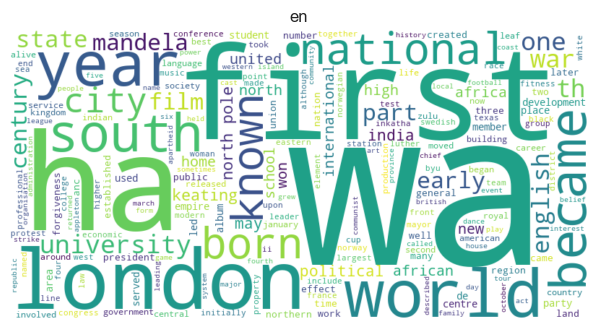

In [341]:
#nube de palabras en ingles


#separando los datos para facilitarnos la creacion de las graficas
groups = textFinal.groupby(textFinal.Language)
textFinalEn = groups.get_group("en")
textFinalNl = groups.get_group("nl")

# Convert float items to strings in the palabras list
palabras_por_categoria = textFinalEn.groupby('Language')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordcloudsEn = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(palabras))
    wordcloudsEn[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(12, 6))
for i, (categoria, wordcloud) in enumerate(wordcloudsEn.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

En el anterior gráfico tenemos un primer acercamiento con las palabras más repetidas del idioma inglés, sin embargo, aunque es bastante gráfica y llamativa, nos presenta la información de una manera poco precisa, por tanto continuaremos desarrollando diagramas que nos permitan apreciar de mejor manera las características del conjunto.

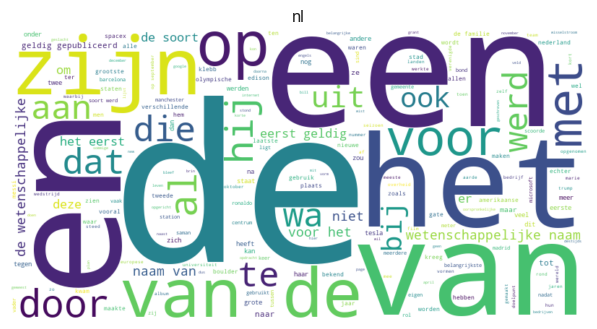

In [342]:
#nube de palabras en holandes

# Convert float items to strings in the palabras list
palabras_por_categoria = textFinalNl.groupby('Language')['token'].apply(lambda x: [str(word) for word in x])

# Create an instance of WordCloud for each category and generate the word cloud
wordcloudsEn = {}
for categoria, palabras in palabras_por_categoria.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(palabras))
    wordcloudsEn[categoria] = wordcloud

# Display the word clouds for each category
plt.figure(figsize=(12, 6))
for i, (categoria, wordcloud) in enumerate(wordcloudsEn.items()):
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(categoria)
    plt.axis('off')
plt.tight_layout()
plt.show()

En el anterior gráfico tenemos un primer acercamiento con las palabras más repetidas del idioma Holandes, sin embargo, aunque es bastante gráfica y llamativa, nos presenta la información de una manera poco precisa, por tanto continuaremos desarrollando diagramas que nos permitan apreciar de mejor manera las características del conjunto.

Cantidad total de palabras:

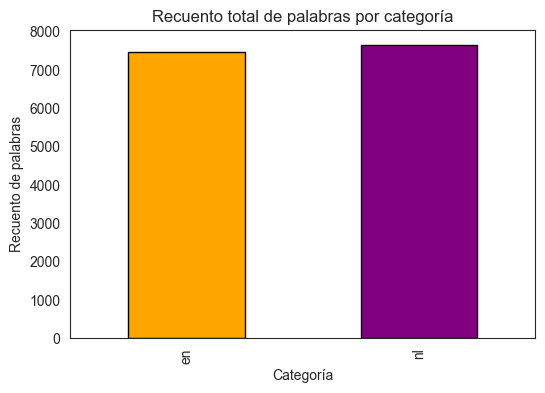

--------------------------
Palabras totales por categoría 👇
--------------------------


Language
en    7474
nl    7653
Name: token, dtype: int64

In [343]:
word_count = textFinal.groupby('Language')['token'].count()

# Crear la tabla gráfica
fig, ax = plt.subplots(figsize=(6, 4))
colors = ['orange', 'purple']  # Colores para las categorías 'ingles' y 'holandes'
word_count.plot(kind='bar', ax=ax, color=colors, edgecolor = 'black', linewidth = 1)
ax.set_xlabel('Categoría')
ax.set_ylabel('Recuento de palabras')
ax.set_title('Recuento total de palabras por categoría')

# Mostrar la tabla gráfica
plt.show()

print('--------------------------')
print('Palabras totales por categoría 👇')
print('--------------------------')
textFinal.groupby(by='Language')['token'].count()

Esta resulta ser una de las métricas más importantes del conjunto, debido a que nos permite saber si el conjunto está desbalanceado, cosa que como podemos apreciar, no ocurre en este caso.

Cantidad de palabras distintas:

In [344]:
print('----------------------------')
print('Palabras distintas por categoria 👇')
print('----------------------------')
textFinal.groupby(by='Language')['token'].nunique()

----------------------------
Palabras distintas por categoria 👇
----------------------------


Language
en    2626
nl    2631
Name: token, dtype: int64

Porcentaje de palabras distintas:

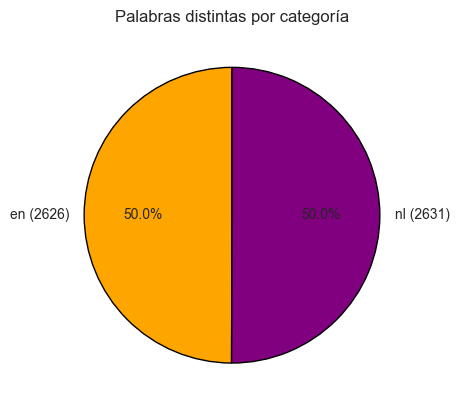

In [345]:
unique_words = textFinal.groupby('Language')['token'].nunique()


# Crear el gráfico de pastel
fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(unique_words, labels=unique_words.index, autopct='%1.1f%%', startangle=90, colors=colors,wedgeprops = {"linewidth": 1, "edgecolor": "black"})

# Agregar los valores numéricos junto a las etiquetas
for i, label in enumerate(texts):
    percentage = label.get_text()
    count = unique_words[i]
    label.set_text(f'{percentage} ({count})')

ax.set_title('Palabras distintas por categoría')

# Mostrar el gráfico de pastel
plt.show()

Podemos ver graficamente que la mitad de las palabras unicas de un idioma son de ingles y la otra mitad son de holandes.

Palabras comunes entre categorias:

In [346]:
palabrasEn = set(textFinal[textFinal.Language == 'en']['token'])
palabrasNl = set(textFinal[textFinal.Language == 'nl']['token'])


print(f"Palabras comunes entre Ingles y Holandes: {len(palabrasEn.intersection(palabrasNl))}")

Palabras comunes entre Ingles y Holandes: 164


Nube de palabras comunes Ingles y Holandes:

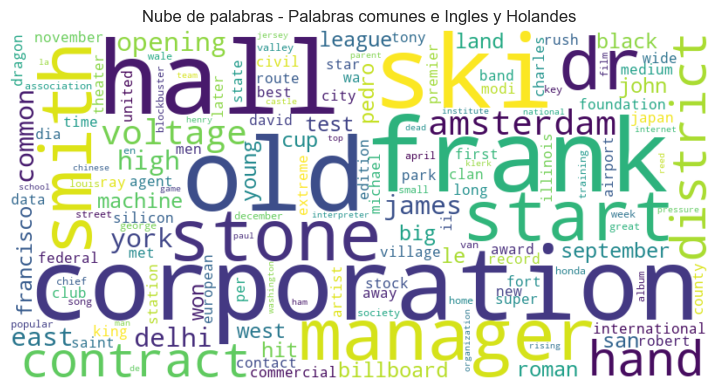

In [347]:
palabras_comunes = palabrasEn.intersection(palabrasNl)
palabras_comunes_lista = list(palabras_comunes)

df_palabras_comunes = pd.DataFrame(palabras_comunes_lista, columns=['Palabra'])
df_palabras_comunes.to_csv('palabras_comunes.csv', index=False)

# Convertir los elementos de palabras_comunes a cadenas de texto
palabras_comunes_str = [str(palabra) for palabra in palabras_comunes]

# Crear una cadena de texto con las palabras comunes
texto_comun = ' '.join(palabras_comunes_str)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comun)

# Mostrar la nube de palabras
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Palabras comunes e Ingles y Holandes')
plt.show()

En el anterior gráfico tenemos un primer acercamiento con las palabras más repetidas en ambos idiomas, sin embargo, aunque es bastante gráfica y llamativa, nos presenta la información de una manera poco precisa, por tanto continuaremos desarrollando diagramas que nos permitan apreciar de mejor manera las características del conjunto.

Segunda prueba:
Es bien sabido que las palabras repetidas en ambos idiomas representan un problema a la hora de determinar el idioma ya que estas están compuestas de nombres propios y palabras con diferente significado e igual escritura, además de pertenecer a cualquiera de los dos conjuntos de datos, afectando así la predicción de la oración en cuestión.
por tanto nos enfrentamos a una difícil decisión, la cual podemos afrontar a partir de dos políticas:

* La primera política sería no eliminar las palabras repetidas debido a que esto reduciría el conjunto de datos sobre el cual trabajamos, sin embargo podría representar una precisión menor.
* La segunda política sería eliminar las palabras repetidas debido a que estas no poseen ningún valor a la hora de determinar el lenguaje de la palabra, aumentando de esta manera la precisión del modelo.

Para dar solución a dicho problema decidimos evaluar ambas políticas al entrenar y probar un modelo con las mismas variables y una entrada de texto diferente (con palabras repetidas y sin palabras repetidas).


Contando la cantidad de palabras repetidas:

In [348]:
pruebas = pd.DataFrame()
pruebas = df.copy()
pruebas["texto_tokenizado"]=df.apply(lambda x: to_array(x), axis=1)
textFinal = textFinal.drop(columns='token')
textFinal = pruebas.explode(column='texto_tokenizado')
textFinal = textFinal.rename(columns={'texto_tokenizado': 'token'})


palabrasEn = set(textFinal[textFinal.Language == 'en']['token'])
palabrasNl = set(textFinal[textFinal.Language == 'nl']['token'])

print(f"Palabras en Ingles: {len(palabrasEn)}, Palabras en Holandes: {len(palabrasEn)}, comunes entre Ingles y Holandes: {len(palabrasEn.intersection(palabrasNl))}")

Palabras en Ingles: 2626, Palabras en Holandes: 2626, comunes entre Ingles y Holandes: 164


Definiendo la funcion de eliminacion de palabras repetidas:

In [349]:
def eliminar_comunes(palabras):
    token=palabras[2]
    respuesta  = set(token)
    respuesta.difference_update(palabras_comunes)
    respuesta = list(respuesta)
    return respuesta
    

Creando el conjunto sin palabras repetidas:

In [350]:
dfCopy["texto_tokenizado"]=pruebas.apply(
    lambda x: eliminar_comunes(x), axis=1)
textFinalCopy["token"]=dfCopy["texto_tokenizado"]
dfCopy.to_csv(
    'resultadoTokenizCopy.csv', index=False)

In [351]:
ruta_archivo = r'./resultadotokenizCopy.csv'

# Leer el archivo CSV
dfCopy = pd.read_csv(ruta_archivo, nrows=100000)

Contando la cantidad de palabras repetidas:

In [352]:
pruebas = dfCopy.copy()
pruebas["texto_tokenizado"]=dfCopy.apply(lambda x: to_array(x), axis=1)
textFinalCopy = textFinalCopy.drop(columns='token')
textFinalCopy = pruebas.explode(column='texto_tokenizado')
textFinalCopy = textFinalCopy.rename(columns={'texto_tokenizado': 'token'})


palabrasEn = set(textFinalCopy[textFinalCopy.Language == 'en']['token'])
palabrasNl = set(textFinalCopy[textFinalCopy.Language == 'nl']['token'])
print(f"Palabras en Ingles: {len(palabrasEn)}, Palabras en Holandes: {len(palabrasEn)}, comunes entre Ingles y Holandes: {len(palabrasEn.intersection(palabrasNl))}")

Palabras en Ingles: 2462, Palabras en Holandes: 2462, comunes entre Ingles y Holandes: 0


A continuación, se evaluará el modelo con ambas politicas, y de esta manera se determinará con cual conjunto de datos trabajaremos a continuación.

In [353]:
datos_X = df['texto_tokenizado']
datos_y = df['Language']

print(datos_X.unique())
print(datos_y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size=0.80,
    random_state=42
)
datos_XCopy = dfCopy['texto_tokenizado']
datos_yCopy = dfCopy['Language']

print(datos_XCopy.unique())
print(datos_yCopy.unique())

X_trainCopy, X_testCopy, y_trainCopy, y_testCopy = train_test_split(
    datos_XCopy,
    datos_yCopy,
    test_size=0.80,
    random_state=42
)# Crear una instancia del vectorizador
vectorizer = CountVectorizer()

# Ajustar el vectorizador con los datos de entrenamiento
vectorizer = CountVectorizer()


# Ajustar el vectorizador con los datos de entrenamiento del conjunto con stopwords
Xtrain = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba utilizando el vectorizador ajustado
Xtest = vectorizer.transform(X_test)

# Ajustar el vectorizador con los datos de entrenamiento del conjunto sin stopwords
XtrainCopy = vectorizer.fit_transform(X_trainCopy)

# Transformar los datos de prueba utilizando el vectorizador ajustado
XtestCopy = vectorizer.transform(X_testCopy)

def cuasiConstantes(Xtrain, Xtest, threshold=0.02):
    # Crear el objeto VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)

    # Aplicar la eliminación de características cuasi-constantes en la matriz tf-idf de entrenamiento
    xtrain = selector.fit_transform(Xtrain)

    # Obtener los índices de las características seleccionadas
    selected_feature_indices = selector.get_support(indices=True)

    # Filtrar la matriz tf-idf de prueba utilizando los índices de características seleccionadas
    xtest = selector.transform(Xtest)

    num_selected_features = xtrain.shape[1]
    print("Número de características seleccionadas:", num_selected_features)

    return xtrain, xtest, selected_feature_indices

xtrain, xtest, selected_feature_indices=cuasiConstantes(Xtrain, Xtest)
xtrainCopy, xtestCopy, selected_feature_indicesCopy=cuasiConstantes(XtrainCopy, XtestCopy)

["['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test']"
 "['president', 'tournament', 'wearing', 'presenting', 'were', 'met', 'africa', 'series', 'the', 'resumption', 'rugby', 'the', 'opening', 'match']"
 "['the', 'the', 'are', 'the', 'reference', 'elli', 'garrard', 'in', 'to', 'fellow', 'referred', 'after', 'cup']"
 ...
 "['uiteindelijk', 'te', 'in', 'tot', 'individuele', 'zomerspelen', 'al', 'maar', 'beste', 'olympische', 'degen', 'koos', 'spelen', 'een']"
 "['degen', 'van', 'olympische', 'en', 'deze', 'van', 'schermen', 'de', 'zilveren', 'sportieve', 'olympische', 'zou', 'individuele', 'uitzondering', 'zijn']"
 "['alle', 'het', 'roeier', 'op', 'zomerspelen', 'zijn', 'berlijn', 'edities', 'in', 'het', 'zowel', 'van', 'uiteindelijk']"]
['en' 'nl']
["['winner', 'south', 'africa', 'permission', 'year', 'after', 'to', 'match']"
 "['president', 'presenting', 'africa', 'wearing', 'match', 'tournament', 'rugby', 'were', 'resumpti

In [354]:
rf_Model = RandomForestClassifier()
def RandomForestFit(x,y,params):
    rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = params, cv = 2, verbose=2, n_jobs = 4)
    rf_Grid.fit(x, y)
    return rf_Grid
aram_grid = {'n_estimators': [100],
               'max_features': ['sqrt'],
               'max_depth': [None],
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               "random_state":[None]       
                }
rf_Grid1 = RandomForestFit(xtrain,y_train,param_grid)
rf_Grid2 = RandomForestFit(xtrainCopy,y_trainCopy,param_grid)

# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba con palabras repetidas
print("Prueba de la primera politica:")
train_accuracy = rf_Grid1.score(xtrain, y_train) * 100
test_accuracy = rf_Grid1.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba sin palabras repetidas
print("Prueba de la segunda politica:")
train_accuracyCopy = rf_Grid2.score(xtrainCopy, y_trainCopy) * 100
test_accuracyCopy = rf_Grid2.score(xtestCopy, y_testCopy) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracyCopy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracyCopy))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Prueba de la primera politica:
Precisión del entrenamiento: 100.000%
Precisión de prueba: 98.713%
Prueba de la segunda politica:
Precisión del entrenamiento: 96.714%
Precisión de prueba: 96.140%


Podemos ver que la política con mejor resultado es la de no eliminar las palabras repetidas, por tanto continuaremos trabajando con el conjunto de datos sin palabras repetidas.

Función de importancia de una palabra:
Se calcula el log odds ratio de cada palabra en el texto y determina si una palabra es más frecuente en la categoría ingles o holandes, para ello utilizaremos la función que se puede apreciar a continuación.

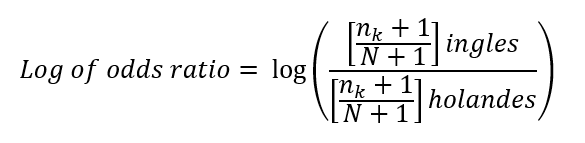

los valores de la fórmula se representan de la siguiente manera:


* nk el número de veces que aparece el término k en los textos de cada categoría y N el número total de términos de cada usuario.
* rotte & fresh: La probabilidad estimada de que la palabra aparezca en la categoría ingles o holandes
* log_odds: El logaritmo de la razón de probabilidades (log odds ratio) de la palabra entre las categorías "inglés" y "holandes".
* abs_log_odds: Este valor representa la magnitud de la diferencia en la probabilidad de la palabra entre las categorías.
* categoría frecuente: La categoría en la que la palabra es más frecuente según el log odds ratio. "inglés" indica que la palabra es más frecuente en la categoría "inglés", y "holandes" indica que es más frecuente en la categoría "holandes".


Los valores positivos indican una asociación más fuerte con la categoría "holandes", mientras que los valores negativos indican una asociación más fuerte con la categoría "inglés".


Calculo de la probabilidad de cada palabra

In [355]:
# Cálculo del log of odds ratio de cada palabra (en vs nl)

# Pivotaje y despivotaje
comentarios_pivot = textFinal.groupby(["Language","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="Language", values= "count")

comentarios_pivot = comentarios_pivot.fillna(value=0)
comentarios_pivot.columns.name = None

comentarios_unpivot = comentarios_pivot.melt(value_name='n', var_name='Language', ignore_index=False)
comentarios_unpivot = comentarios_unpivot.reset_index()

# Selección de las categorias en y nl
comentarios_unpivot = comentarios_unpivot[comentarios_unpivot.Language.isin(['en', 'nl'])]

# Se añade el total de palabras de cada categoria
comentarios_unpivot = comentarios_unpivot.merge(
                    textFinal.groupby('Language')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'Language'
                 )

# Cálculo de odds y log of odds de cada palabra
comentarios_logOdds = comentarios_unpivot.copy()
comentarios_logOdds['odds'] = (comentarios_logOdds.n + 1) / (comentarios_logOdds.N + 1)
comentarios_logOdds = comentarios_logOdds[['token', 'Language', 'odds']] \
                    .pivot(index='token', columns='Language', values='odds')
comentarios_logOdds.columns.name = None

comentarios_logOdds['log_odds']     = -1*np.log(comentarios_logOdds.en/comentarios_logOdds.nl)
comentarios_logOdds['abs_log_odds'] = np.abs(comentarios_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de en. Esto es así porque el ratio se ha
# calculado como en/nl.

comentarios_logOdds['categoria frecuente'] = np.where(comentarios_logOdds.log_odds > 0,
                                              "nl",
                                              "en"
                                    )

Top 15 palabras mas representativas:

In [356]:
print('-----------------------------------')
print('Top 15 palabras más diferenciadoras 👇')
print('-----------------------------------')
comentarios_logOdds.sort_values('abs_log_odds', ascending=False).head(15)

-----------------------------------
Top 15 palabras más diferenciadoras 👇
-----------------------------------


,en,nl,log_odds,abs_log_odds,categoria frecuente
token,,,,,
het,0.000134,0.031487,5.461133,5.461133,nl
een,0.000134,0.028482,5.360831,5.360831,nl
van,0.000268,0.040240,5.013288,5.013288,nl
to,0.018462,0.000131,-4.950918,4.950918,en
voor,0.000134,0.013457,4.611065,4.611065,nl
en,0.000268,0.026653,4.601309,4.601309,nl
op,0.000134,0.012412,4.530213,4.530213,nl
zijn,0.000134,0.012020,4.498124,4.498124,nl
and,0.035184,0.000392,-4.497206,4.497206,en


En la tabla anterior se puede apreciar mucha información relevante a partir de la importancia de la palabra en ambos idiomas, si bien no es muy gráfica o muy vistosa, permite estudiar de mejor manera el comportamiento de dichas palabras al presentar una mayor cantidad de datos que otras representaciones gráficas.

Text(0.5, 0, 'log odds ratio (ingles / holandes)')

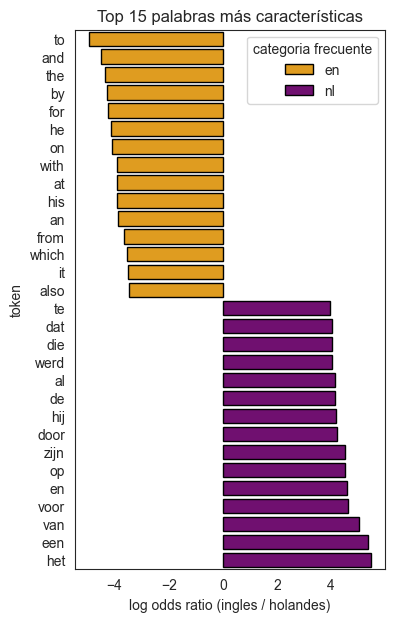

In [357]:
top_30 = comentarios_logOdds[['log_odds', 'abs_log_odds', 'categoria frecuente']] \
        .groupby('categoria frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.set_style(style="white",rc= {'patch.edgecolor': 'black'})
sns.barplot(
    x='log_odds',
    y='token',
    hue='categoria frecuente',
    data=top_30,
    ax=ax,
    palette=["orange","purple"]
)
ax.set_title('Top 15 palabras más características')
ax.set_xlabel('log odds ratio (ingles / holandes)')

El grafico anterior nos permite apreciar de manera mas grafica las palabras con mayor peso en ambos idiomas.

Frecuencia de las palabras:
Otro valor importante además del peso de la palabra en ambos lenguajes, es la frecuencia de cada término, podremos calcular la frecuencia de cada término en el texto mediante el cálculo del Term Frequency (tf) y Inverse Document Frequency (idf).

* tf: frecuencia relativa de cada término.
* idf: es útil para calcular la importancia relativa de cada término

Calculando tf:


In [358]:
tf = textFinal.copy()
# Número de veces que aparece cada término en cada comentario
tf = tf.groupby(["token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por comentario
tf['total_count'] = tf.groupby('token')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(10)

,token,count,total_count,tf
0,a1a1aa,1,1,1.0
3398,plating,1,1,1.0
3397,plateau,1,1,1.0
3396,plate,1,1,1.0
3395,plastic,2,2,1.0
3394,planning,2,2,1.0
3393,plannen,2,2,1.0
3392,planeet,1,1,1.0
3391,plan,4,4,1.0
3390,plain,1,1,1.0


En la tabla anterior, se puede apreciar la frecuencia relativa de cada uno de los terminos.

Calculando idf:

In [359]:
idf = textFinal.copy()
total_documents = idf["token"].drop_duplicates().count()
# Número de comentarios en los que aparece cada término
idf = idf.groupby(["token"])["token"].agg(["count"]).reset_index()
idf[' n_comentarios'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf[' n_comentarios'])
idf = idf[["token"," n_comentarios", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_comentarios,idf
4355,the,622,2.102682
1040,de,597,2.143705
2109,in,506,2.309086


En esta tabla podemos observa el número de Inverse Document Frequency ademas del número de comentarios en los que aparece cada término.

A partir de este punto realizaremos el cálculo de la importancia de cada una de las palabras guardando el indicador en la columna "tf_idf" del dataframe tf_idf y apoyandonos en los valores de tf e idf, de la siguiente manera:

tf * idf

Esto nos permitirá identificar los términos más relevantes y distintivos en un conjunto de documentos.

Calculando tf_idf:


In [360]:
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="token").head()

,token,count,total_count,tf,n_comentarios,idf,tf_idf
0,a1a1aa,1,1,1.0,1,8.535622,8.535622
1,aa,1,1,1.0,1,8.535622,8.535622
2,aaaa,1,1,1.0,1,8.535622,8.535622
3,aaaaaa,1,1,1.0,1,8.535622,8.535622
4,aabel,1,1,1.0,1,8.535622,8.535622


Creando el conjunto de datos final:

In [361]:
# Acceder a los datos de las columnas
Language = df['Language']
Text = df['Text']
texto_tokenizado = df['texto_tokenizado']

df.head()

,Language,Text,texto_tokenizado
0,en,"and Africa in permission winners,[25] of in ye...","['and', 'africa', 'in', 'permission', 'winner'..."
1,en,President tournament wearing presenting were m...,"['president', 'tournament', 'wearing', 'presen..."
2,en,The the are 'The thirty-eight reference as Ell...,"['the', 'the', 'are', 'the', 'reference', 'ell..."
3,en,a The Rugby In and Warrant head 'The Webb and ...,"['the', 'rugby', 'in', 'and', 'warrant', 'head..."
4,en,an high - The game engraved Crown Football two...,"['an', 'high', 'the', 'game', 'engraved', 'cro..."


A continuación crearemos los conjuntos de prueba y entrenamiento, apoyandonos en la función train_test_split, dicha función recibe los siguientes parámetros:

* arrays: Las entradas permitidas son listas, matrices numpy, matrices scipy-sparse o marcos de datos pandas.
* test_size: Si es flotante, debe estar entre 0,0 y 1,0 y representar la proporción del conjunto de datos que se incluirá en la división de prueba. Si es int, representa el número absoluto de muestras de prueba. Si es Ninguno, el valor se establece en el complemento del tamaño del tren. Si train_sizetambién es Ninguno, se establecerá en 0,25.
* random_state: Controla la mezcla aplicada a los datos antes de aplicar la división. Pase un int para obtener una salida reproducible en múltiples llamadas a funciones.

In [362]:
datos_X = df['texto_tokenizado']
datos_y = df['Language']

print(datos_X.unique())
print(datos_y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size=0.80,
    random_state=42
)

["['and', 'africa', 'in', 'permission', 'winner', 'of', 'in', 'year', 'to', 'south', 'after', 'match', 'of', 'test']"
 "['president', 'tournament', 'wearing', 'presenting', 'were', 'met', 'africa', 'series', 'the', 'resumption', 'rugby', 'the', 'opening', 'match']"
 "['the', 'the', 'are', 'the', 'reference', 'elli', 'garrard', 'in', 'to', 'fellow', 'referred', 'after', 'cup']"
 ...
 "['uiteindelijk', 'te', 'in', 'tot', 'individuele', 'zomerspelen', 'al', 'maar', 'beste', 'olympische', 'degen', 'koos', 'spelen', 'een']"
 "['degen', 'van', 'olympische', 'en', 'deze', 'van', 'schermen', 'de', 'zilveren', 'sportieve', 'olympische', 'zou', 'individuele', 'uitzondering', 'zijn']"
 "['alle', 'het', 'roeier', 'op', 'zomerspelen', 'zijn', 'berlijn', 'edities', 'in', 'het', 'zowel', 'van', 'uiteindelijk']"]
['en' 'nl']


Vectorizamos los datos:

In [363]:
# Crear una instancia del vectorizador
vectorizer = CountVectorizer()

# Ajustar el vectorizador con los datos de entrenamiento
Xtrain = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba utilizando el vectorizador ajustado
Xtest = vectorizer.transform(X_test)

print(Xtrain.shape)

tokens = vectorizer.get_feature_names_out()
print("Tokens:", tokens)

print("Tokens:", len(tokens))

print("Conjunto de entrenamiento - Características:", Xtrain.shape)
print("Conjunto de entrenamiento - Etiquetas:", y_train.shape)
print("Conjunto de prueba - Características:", Xtest.shape)
print("Conjunto de prueba - Etiquetas:", y_test.shape)

(213, 1492)
Tokens: ['aan' 'aandelen' 'aangrenzende' ... 'zwart' 'zwelethini' 'zwitserse']
Tokens: 1492
Conjunto de entrenamiento - Características: (213, 1492)
Conjunto de entrenamiento - Etiquetas: (213,)
Conjunto de prueba - Características: (855, 1492)
Conjunto de prueba - Etiquetas: (855,)


Seleccion de caracteristicas:
La Selección de Características es el proceso de seleccionar las más importante y/o relevante características de un conjunto de datos, con el objetivo de mejorar el rendimiento de predicción de los predictores, proporcionar predictores más rápidos y más rentables y proporcionar una mejor comprensión del proceso subyacente que generó los datos.
La aplicación de estos métodos busca reducir el número de características basadas en filtros para obtener así subconjuntos de características.
en este trabajo utilizaremos dos de estos métodos para generar diferentes conjuntos de datos, dichos conjuntos de datos son:

* Cuasi-Constantes.
* Selección de Características Random (RFE).

Selección de características Cuasi-Constantes:
este selector de características es parte de un conjunto de metodos de seleccion de caracteristicas llamados Métodos de filtro, los cuales funcionan de la siguiente manera:


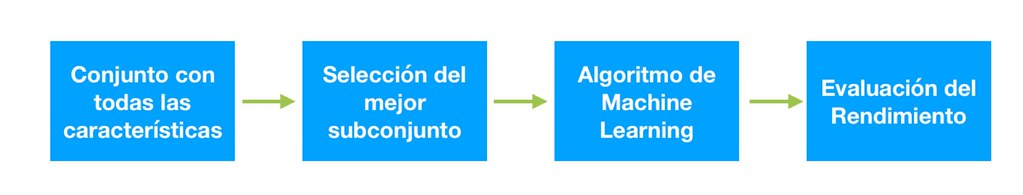


Los métodos de filtro se utilizan generalmente como un paso de preprocesamiento de datos y la selección de características por filtro es independiente de cualquier algoritmo de Machine Learning.


Las características se clasifican según los puntajes estadísticos que tienden a determinar la correlación de las características (en este caso con respecto a la variable x), tenga en cuenta que la correlación es un término cuya interpretación varía dependiendo del trabajo.  


También es necesario saber que los métodos de filtro no eliminan la multicolinealidad, por lo tanto se debe lidiar con ellos también antes de entrenar modelos para los datos.


En nuestro modelo seleccionaremos una serie de características basándonos en la varianza de los resultados con respecto a la media de valores de la variable x en este caso representada por la columna "text_tokenizado" del dataframe df, eliminando valores que estén fuera de dicha media de valores, lo que se podría traducir como **la eliminación de los valores de la columna "text_tokenizado" que cuenten con menos cantidad de palabras comunes**.


Accederemos a este concepto por medio de la función:


* VarianceThreshold (eliminando los valores que tengan una varianza mayor a **0.02** con respecto a la media)


*debido a nuestra implementación de la función de selección de características Cuasi-Constantes y la forma en la que esta opera (trabajando en los datos de la variable x y eliminando los valores con una varianza fuera de la media), este metodo de seleccion tambien puede ser aplicado a implementaciones de trabajo no supervisado.*


Posteriormente seleccionamos las características en base a VarianceThreshold y utilizando la función fit_transform la cual nos retorna un conjunto nuevo con las nuevas características seleccionadas.


In [364]:
def cuasiConstantes(Xtrain, Xtest, threshold=0.02):
    # Crear el objeto VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)

    # Aplicar la eliminación de características cuasi-constantes en la matriz tf-idf de entrenamiento
    xtrain = selector.fit_transform(Xtrain)

    # Obtener los índices de las características seleccionadas
    selected_feature_indices = selector.get_support(indices=True)

    # Filtrar la matriz tf-idf de prueba utilizando los índices de características seleccionadas
    xtest = selector.transform(Xtest)

    num_selected_features = xtrain.shape[1]
    print("Número de características seleccionadas:", num_selected_features)

    return xtrain, xtest, selected_feature_indices

xtrain, xtest, selected_feature_indices=cuasiConstantes(Xtrain, Xtest)

Número de características seleccionadas: 79


Seleccion de caracteristicas random (RFE):
este selector de características es parte de un conjunto de metodos de seleccion de caracteristicas llamados Métodos de envoltura, los cuales funcionan de la siguiente manera:

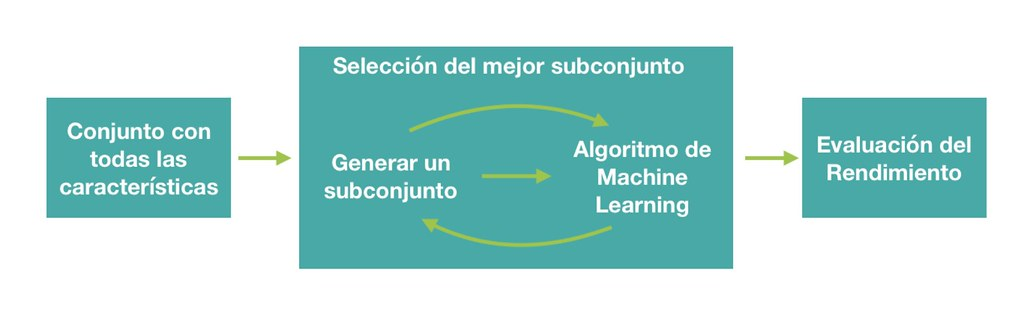

Como puedes observar, un método de envoltura necesita un algoritmo de Machine Learning y utiliza su rendimiento como criterio de evaluación. Este método busca una característica que sea más adecuada para el algoritmo y tiene como objetivo mejorar el rendimiento.

Por lo tanto, tratamos de usar un subconjunto de características y entrenamos un modelo usándolos, basándonos en las inferencias que extraemos del modelo anterior, decidimos agregar o eliminar características de su subconjunto. El problema se reduce esencialmente a un problema de búsqueda.

Sin embargo es necesario tener en cuenta que estos métodos suelen ser computacionalmente muy caros.

en nuestro modelo seleccionaremos una serie de características basándose en RFE y apoyándonos en un clasificador de características Random Forest.

* Random Forest: Un bosque aleatorio es un metaestimador que ajusta una serie de clasificadores de árboles de decisión en varias submuestras del conjunto de datos y utiliza promedios para mejorar la precisión predictiva y controlar el sobreajuste.
* Eliminación de características recursivas (RFE): es un algoritmo de optimización que busca encontrar el subconjunto de funciones con mejor rendimiento. Crea repetidamente modelos y deja de lado la mejor o la peor característica de rendimiento en cada iteración. Construye el siguiente modelo con las características de la izquierda hasta que se agotan todas las características, luego clasifica las características según el orden de su eliminación.

Accederemos a ambos conceptos por medio de las funciones:

* RandomForestClassifier.
* RFE.

Para posteriormente seleccionar las características en base a estos y utilizando la función fit_transform la cual nos retorna un nuevo conjunto con las nuevas características seleccionadas.


In [365]:

def ScaracteristicasRandom(xtrain, y_train, n_estimators=100, max_depth=None, min_samples_split=2):
    # Crear un estimador Random Forest con parámetros ajustados
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, n_jobs=-1)

    # Crear un selector RFE con Random Forest y ranking
    rfe = RFE(estimator=rf, step=2)

    # Aplicar RFE al conjunto de datos
    xtrainE = rfe.fit_transform(xtrain, y_train)
    # Obtener las características seleccionadas
    selected_features = rfe.support_
    num_selected_features = sum(selected_features)
    print("Número de características seleccionadas:", num_selected_features)

    # Obtener el ranking de importancia de características
    feature_ranking = rfe.ranking_
    # Imprimir las características seleccionadas
        

    return xtrainE, selected_features, feature_ranking

xtrainE, selected_features, feature_ranking = ScaracteristicasRandom(xtrain, y_train)
# Conjunto de prueba transformado
xtestE = xtest[:, selected_features]  

Número de características seleccionadas: 39


## Seleccionar el o los modelos.
En la siguiente sección de la investigación seleccionaremos los modelos a utilizar en el resto del trabajo, sin embargo, debido a que se trata de un trabajo académico con el objetivo de evaluar la implementación de una serie de métodos en específicos, evaluaremos el rendimiento de los siguientes modelos:

* Random Forest.
* Árboles de decisión.
* Redes neuronales.
* Redes neuronales profundas (Bonus).

Si bien el trabajo consiste en implementar los 3 primeros modelos, decidimos implementar un cuarto método con el objetivo de permitirnos conocer más acerca de los modelos estudiados y realizar una investigación adicional que nos permita aumentar la precisión del modelo a seleccionar, para dar solución a la pregunta anteriormente planteada.


## Ajustar y evaluar los modelos.
A patir de de este punto se dara inicio a la implementacion y analisis detallado de los modelos mencionados con anterioridad🤖.

Árboles de decisión 🌳

Un árbol de decisión es un algoritmo de aprendizaje supervisado no paramétrico, que se utiliza tanto para tareas de clasificación como de regresión. Tiene una estructura de árbol jerárquica, que consta de un nodo raíz, ramas, nodos internos y nodos hoja.
un árbol de decisión comienza con un nodo raíz, que no tiene ramas entrantes. Las ramas salientes del nodo raíz alimentan los nodos internos, también conocidos como nodos de decisión. En función de las características disponibles, ambos tipos de nodos realizan evaluaciones para formar subconjuntos homogéneos, que se indican mediante nodos hoja o nodos terminales. Los nodos hoja representan todos los resultados posibles dentro del conjunto de datos.

Creando instancia de arbol de desicion:

In [366]:
rf_Model = DecisionTreeClassifier()

Creando funcion de entrenamiento arbol de desicion:

In [367]:
def DecisionTreeFit(x,y,params):
    rf_Grid = GridSearchCV(
        estimator = rf_Model, 
        param_grid = params,
        refit=True,
        n_jobs=-1,
        cv=5,
    )
    rf_Grid.fit(x, y)
    return rf_Grid

Pruebas con parámetros por defecto y seleccion de caracteristicas Cuasi-Constantes:

Estableciendo parametros (por defecto):

In [368]:
param_grid = {
    'criterion': ['gini'],
    "splitter":["best"],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [None]
}
print(param_grid)

{'criterion': ['gini'], 'splitter': ['best'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': [None]}


Descripción de los parámetros:

* Criterion: La función para medir la calidad de una división. Los criterios admitidos son "gini" para la impureza de Gini y "log_loss" y "entropía", ambos para la ganancia de información de Shannon; consulte Formulación matemática . Nota: Este parámetro es específico del árbol.
* splitter:La estrategia utilizada para elegir la división en cada nodo. Las estrategias admitidas son "mejores" para elegir la mejor división y "aleatorias" para elegir la mejor división aleatoria.
* max_depth: La profundidad máxima del árbol.
* min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno.
* min_samples_leaf: El número mínimo de muestras necesarias para estar en un nodo de hoja.
* max_features: La cantidad de características a considerar al buscar la mejor división, la búsqueda de una división no se detiene hasta que se encuentra al menos una partición válida de las muestras de nodos.

Entrenando:

In [369]:
rf_Grid = DecisionTreeFit(xtrain,y_train,param_grid)

Analizando resultados:

In [370]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [371]:
rf_Grid.best_score_

0.9576965669988926

In [372]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.96      0.98      0.97       428
          nl       0.98      0.96      0.97       427

    accuracy                           0.97       855
   macro avg       0.97      0.97      0.97       855
weighted avg       0.97      0.97      0.97       855



In [373]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 97.193%


Prueba con Hiperparámetros y seleccion de caracteristicas Cuasi-Constantes:

Estableciendo parametros:

In [374]:
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    "splitter":["best", "random"],
    'max_depth': [int(x) for x in np.linspace(start=50, stop=300, num=6)]+[None],
    'min_samples_split': [int(x) for x in np.linspace(start=2, stop=10, num=5)]+[None],
    'min_samples_leaf': [int(x) for x in np.linspace(start=2, stop=15, num=14)]+[None],
    'max_features': [int(x) for x in np.linspace(start=1, stop=10, num=10)]
}
print(param_grid)

{'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [50, 100, 150, 200, 250, 300, None], 'min_samples_split': [2, 4, 6, 8, 10, None], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


Entrenando:

In [375]:
rf_Grid = DecisionTreeFit(xtrain,y_train,param_grid)

Analizando resultados:

In [ ]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': 300,
 'max_features': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'splitter': 'best'}

In [ ]:
rf_Grid.best_score_

0.9906976744186047

In [ ]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       0.92      1.00      0.96       105
          nl       1.00      0.92      0.96       108

    accuracy                           0.96       213
   macro avg       0.96      0.96      0.96       213
weighted avg       0.96      0.96      0.96       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.90      0.99      0.94       428
          nl       0.99      0.89      0.94       427

    accuracy                           0.94       855
   macro avg       0.94      0.94      0.94       855
weighted avg       0.94      0.94      0.94       855



In [ ]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 95.775%
Precisión de prueba: 93.918%


Prueba con Hiperparametros y seleccion de caracteristicas Random (RFE):

Estableciendo parametros:

In [ ]:
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    "splitter":["best", "random"],
    'max_depth': [int(x) for x in np.linspace(start=50, stop=300, num=6)]+[None],
    'min_samples_split': [int(x) for x in np.linspace(start=2, stop=10, num=5)]+[None],
    'min_samples_leaf': [int(x) for x in np.linspace(start=2, stop=15, num=14)]+[None],
    'max_features': [int(x) for x in np.linspace(start=1, stop=10, num=10)]
}
print(param_grid)

{'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [50, 100, 150, 200, 250, 300, None], 'min_samples_split': [2, 4, 6, 8, 10, None], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


Entrenando:

In [ ]:
rf_Grid = DecisionTreeFit(xtrainE,y_train,param_grid)

Analizando resultados:

In [ ]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': 250,
 'max_features': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'splitter': 'best'}

In [ ]:
rf_Grid.best_score_

0.9952380952380953

In [ ]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
y_pred_train = rf_Grid.predict(xtrainE)
y_pred_test  = rf_Grid.predict(xtestE)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       0.97      1.00      0.99       105
          nl       1.00      0.97      0.99       108

    accuracy                           0.99       213
   macro avg       0.99      0.99      0.99       213
weighted avg       0.99      0.99      0.99       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.96      1.00      0.98       428
          nl       1.00      0.96      0.97       427

    accuracy                           0.98       855
   macro avg       0.98      0.98      0.98       855
weighted avg       0.98      0.98      0.98       855



In [ ]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrainE, y_train) * 100
test_accuracy = rf_Grid.score(xtestE, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 98.592%
Precisión de prueba: 97.544%


A partir de la ejecución de las pruebas en los modelos, podemos ver los siguiente resultados:

* Resultados de prueba con parámetros por defecto y selección de características Cuasi-Constantes:
    1. precisión en datos de entrenamiento: 100%
    2. precisión en datos de prueba: 97.544%

* Resultados de prueba con Hiperparametros y selección de características Cuasi-Constantes:
    1. precisión en datos de entrenamiento: 95.775%
    2. precisión en datos de prueba: 93.450%

* Resultados de prueba con Hiperparametros y seleccion de caracteristicas random(RFE):
    1. precisión en datos de entrenamiento: 97.653%
    2. precisión en datos de prueba: 94.737%

Interpretando estos resultados, podemos ver que a pesar de que la configuración de variables más óptima es la de la prueba por defecto, el conjunto de prueba más preciso es el de características random (RFE), por tanto, realizaremos las siguientes pruebas:

* Prueba con parámetros por defecto y selección de características random (RFE).
* Prueba con parámetros por defecto modificando las características que según el selector de características GridSearchCV y bajo mi propio criterio dieron mejores resultados en la segunda prueba y selección de características random (RFE).
* Prueba con parámetros por defecto modificando las características que según el selector de características GridSearchCV y bajo mi propio criterio dieron mejores resultados en la segunda prueba y selección de características random (RFE).

pruebas de ajuste:

A continuación se realizan tres pruebas con diferentes hiperparámetros con el objetivo de perfeccionar el modelo a partir de las configuraciones y resultados obtenidos en las pruebas anteriores.

Estableciendo los parametros de los modelos:

In [ ]:
param_sets = [
    {
        "fit":{
            "x":xtrainE,
            "y":y_train
        },
        "test":{
            "x":xtestE,
            "y":y_test
        },
        "params":{
            'criterion': ['gini'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': [None]
        }
    },
    {
        "fit":{
            "x":xtrainE,
            "y":y_train
        },
        "test":{
            "x":xtestE,
            "y":y_test
        },
        "params":{
            'criterion': ['gini'],
            'max_depth': [None],
            'max_features': [9],
            'min_samples_leaf':[1],
            'min_samples_split': [2],
            'splitter': ['best']
        }
    },
    {
        "fit":{
            "x":xtrainE,
            "y":y_train
        },
        "test":{
            "x":xtestE,
            "y":y_test
        },
        "params":{
            'criterion': ['gini'],
            'max_depth': [None],
            'max_features': [9],
            'min_samples_leaf': [1],
            'min_samples_split': [2],
            'splitter': ['random']
        }
    },
]

Ejecutando el modelo:

In [ ]:
for i, params in enumerate(param_sets):
    start_time = time.time()  # Registrar el tiempo de inicio
    
    # Crear una instancia del modelo TreeDecisionClassifier
    rf_Grid = DecisionTreeFit(params["fit"]["x"],params["fit"]["y"],params["params"])
    
    # Entrenar el modelo con los parámetros actuales

    bestParams=rf_Grid.best_params_
    train_accuracy = rf_Grid.score(params["fit"]["x"], params["fit"]["y"]) * 100
    test_accuracy = rf_Grid.score(params["test"]["x"],params["test"]["y"]) * 100
    
    end_time = time.time()  # Registrar el tiempo de finalización
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido

    # Redondear el tiempo transcurrido a dos decimales
    elapsed_time = round(elapsed_time, 2)
    
    # Imprimir los resultados con el número de prueba, tiempo de ejecución y precisión en %
    print("Número de prueba: ", i+1)
    print("Parámetros: ", params["params"])
    print("Precisión de entrenamiento: ", "{:.2f}%".format(train_accuracy))
    print("Precisión de prueba: ", "{:.2f}%".format(test_accuracy))
    print("mejores parametros: ", bestParams)
    print("Tiempo de ejecución : ", elapsed_time, "segundos")
    print("--------------------------------------")

Número de prueba:  1
Parámetros:  {'criterion': ['gini'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': [None]}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  97.19%
mejores parametros:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tiempo de ejecución :  0.02 segundos
--------------------------------------
Número de prueba:  2
Parámetros:  {'criterion': ['gini'], 'max_depth': [None], 'max_features': [9], 'min_samples_leaf': [1], 'min_samples_split': [2], 'splitter': ['best']}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  95.09%
mejores parametros:  {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Tiempo de ejecución :  0.02 segundos
--------------------------------------
Número de prueba:  3
Parámetros:  {'criterion': ['gini'], 'max_depth': [None], 'max_features': [9], 'min_sampl

Conclusión:
a partir de las pruebas realizadas, podemos determinar que la mejor configuración para el modelo de inteligencia artificial, árbol de decisión es:

{
    'criterion': ['gini'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [None]
}

también conocida como la configuración por defecto, implementada en conjunto con el selector de características random (RFE), sin embargo, esta configuración tiene todavía campo para mejoras, permitiéndonos aumentar la precisión del modelo, más específicamente en la partición de prueba, debido a que a diferencia de las pruebas en el conjunto de entrenamiento, estas presentan un porcentaje de precisión menor.
algunas de las estrategias que podríamos implementar para aumentar la precisión del modelo son las siguientes:

* Ampliar la cantidad de datos del conjunto: esto nos permitiría realizar estimaciones aún más precisas en los datos de prueba, debido a que el modelo se enfrenta a una mayor cantidad de nodos del árbol, permitiéndole identificar patrones más complejos y realizar estimaciones más precisas.
* Probar diferentes selectores de características: como pudo apreciarse en la mejoría al cambiar el selector de características de Cuasi-Constantes a Random(RFE), estos juegan un papel importante en el ajuste del modelo, por tanto considero que probar con una mayor cantidad de selectores de características, podría brindarnos mejores resultados.
* Probar nuevas configuraciones: si bien obtuvimos mejores resultados con las configuraciones por defecto, una vez aplicadas las políticas anteriores, podríamos darle un poco más de precisión al modelo explorando con nuevas configuraciones, específicamente en los parámetros "max_depth" y "max_features".

Random Forest 🌄

El bosque aleatorio es un algoritmo de aprendizaje automático de uso común, registrado por Leo Breiman y Adele Cutler, que combina el resultado de múltiples árboles de decisión para alcanzar un único resultado. Su facilidad de uso y flexibilidad han impulsado su adopción, ya que maneja problemas tanto de clasificación como de regresión.
es importante destacar que dicho modelo ha sido catalogado como uno de los modelos de inteligencia artificial mas robustos, debido a su filosofia de emplear un modelo liviano como lo son los arboles de decision aprovechando sus caracteristicas en un modelo mas grande y complejo.

Creando instancia de random forest:

In [ ]:
rf_Model = RandomForestClassifier()

Creando funcion de entrenamiento de bosque random:

In [ ]:
def RandomForestFit(x,y,params):
    rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = params, refit=True, n_jobs=-1, cv=5)
    rf_Grid.fit(x, y)
    return rf_Grid

Pruebas para random forest con parámetros por defecto:

Estableciendo parametros (por defecto):

In [ ]:
param_grid = {'n_estimators': [100],
               "criterion":["gini"],
               'max_features': ['sqrt'],
               'max_depth': [None],
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               "random_state":[None]       
                }
print(param_grid)

{'n_estimators': [100], 'criterion': ['gini'], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'random_state': [None]}


Descripción de parámetros:

* n_estimators: La cantidad de árboles en el bosque.
* max_features: La función para medir la calidad de una división.
* max_depth: La profundidad máxima del árbol.
* min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno.
* min_samples_leaf: El número mínimo de muestras necesarias para estar en un nodo de hoja.
* random_state: Controla tanto la aleatoriedad del arranque de las muestras utilizadas al construir árboles (if bootstrap=True) como el muestreo de las características a considerar al buscar la mejor división en cada nodo (if ).

Entrenando:

In [ ]:
rf_Grid = RandomForestFit(xtrain,y_train,param_grid)

Analizando resultados:

In [ ]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': None}

In [ ]:
# Generando matriz de confusion
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.98      0.99      0.98       428
          nl       0.99      0.98      0.98       427

    accuracy                           0.98       855
   macro avg       0.98      0.98      0.98       855
weighted avg       0.98      0.98      0.98       855



In [ ]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 98.480%


Prueba con Hiperparámetros y seleccion de caracteristicas Cuasi-Constantes:

Estableciendo parametros:

In [ ]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=300, num=3)],
               "criterion":["gini"],
               'max_features': ["sqrt", "log2", None],
               'max_depth': [None],
               'min_samples_split': [int(x) for x in np.linspace(start=4, stop=8, num=3)]+[None],
               'min_samples_leaf': [int(x) for x in np.linspace(start=4, stop=8, num=3)]+[None],
               "random_state":[int(x) for x in np.linspace(start=20, stop=40, num=2)]       
            }
print(param_grid)      
                

{'n_estimators': [200, 250, 300], 'criterion': ['gini'], 'max_features': ['sqrt', 'log2', None], 'max_depth': [None], 'min_samples_split': [4, 6, 8, None], 'min_samples_leaf': [4, 6, 8, None], 'random_state': [20, 40]}


Entrenando:

In [ ]:
rf_Grid = RandomForestFit(xtrain,y_train,param_grid)

Analizando resultados:

In [ ]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 200,
 'random_state': 20}

In [ ]:
# Generando matriz de confusion
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       0.99      1.00      1.00       105
          nl       1.00      0.99      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.98      0.99      0.99       428
          nl       0.99      0.98      0.99       427

    accuracy                           0.99       855
   macro avg       0.99      0.99      0.99       855
weighted avg       0.99      0.99      0.99       855



In [ ]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 99.531%
Precisión de prueba: 98.830%


Prueba con Hiperparametros y seleccion de caracteristicas Random (RFE):

Estableciendo parametros:

In [ ]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=300, num=3)],
               "criterion":["gini"],
               'max_features': ["sqrt", "log2", None],
               'max_depth': [None],
               'min_samples_split': [int(x) for x in np.linspace(start=4, stop=8, num=3)]+[None],
               'min_samples_leaf': [int(x) for x in np.linspace(start=4, stop=8, num=3)]+[None],
               "random_state":[int(x) for x in np.linspace(start=20, stop=40, num=2)]       
            }

print(param_grid)

{'n_estimators': [200, 250, 300], 'criterion': ['gini'], 'max_features': ['sqrt', 'log2', None], 'max_depth': [None], 'min_samples_split': [4, 6, 8, None], 'min_samples_leaf': [4, 6, 8, None], 'random_state': [20, 40]}


Entrenando:

In [291]:
rf_Grid = RandomForestFit(xtrainE,y_train,param_grid)

Analizando resultados:

In [292]:
rf_Grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 200,
 'random_state': 20}

In [293]:
# Generando matriz de confusion
y_pred_train = rf_Grid.predict(xtrainE)
y_pred_test  = rf_Grid.predict(xtestE)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       0.99      1.00      1.00       105
          nl       1.00      0.99      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.97      0.99      0.98       428
          nl       0.99      0.97      0.98       427

    accuracy                           0.98       855
   macro avg       0.98      0.98      0.98       855
weighted avg       0.98      0.98      0.98       855



In [294]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrainE, y_train) * 100
test_accuracy = rf_Grid.score(xtestE, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 99.531%
Precisión de prueba: 98.129%


A partir de la ejecución de las pruebas en los modelos, podemos ver los siguiente resultados:

* Resultados de prueba con parámetros por defecto y selección de características Cuasi-Constantes:
    1. precisión en datos de entrenamiento: 100%
    2. precisión en datos de prueba: 99.181%

* Resultados de prueba con Hiperparametros y selección de características Cuasi-Constantes:
    1. precisión en datos de entrenamiento: 99.531%
    2. precisión en datos de prueba: 98.830%

* Resultados de prueba con Hiperparametros y seleccion de caracteristicas random(RFE):
    1. precisión en datos de entrenamiento: 99.531%
    2. precisión en datos de prueba: 98.012%

Interpretando estos resultados, podemos ver que la configuración de variables más óptima es la de la prueba por defecto y el conjunto de prueba más preciso es el de características Cuasi-Constantes por muy poco, por tanto, realizaremos las siguientes pruebas:

* Prueba con parámetros por defecto modificando las características que bajo mi criterio podrían optimizar el modelo y selección de características Cuasi-Constantes.
* Prueba con parámetros por defecto modificando las características que según el selector de características GridSearchCV y bajo mi criterio dieron mejores resultados en la segunda prueba y selección de características Cuasi-Constantes.
* Prueba con parámetros por defecto modificando las características que según el selector de características Grid Search CV y bajo mi criterio dieron mejores resultados en la segunda prueba y selección de características Cuasi-Constantes.

pruebas de ajuste:

A continuación se realizan tres pruebas con diferentes hiperparámetros con el objetivo de perfeccionar el modelo a partir de las configuraciones y resultados obtenidos en las pruebas anteriores.

Estableciendo los parametros de los modelos:

In [295]:
param_sets = [
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'n_estimators': [100],
            "criterion":["gini"],
            'max_features': ['sqrt'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [2],
            "random_state":[20]       
        }
    },
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'n_estimators': [100],
            "criterion":["gini"],
            'max_features': ['log2'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            "random_state":[None]       
        }
    },
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'n_estimators': [200],
            "criterion":["gini"],
            'max_features': ['log2'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            "random_state":[None]       
        }
    },
]


ejecutando los modelos:

In [296]:
for i, params in enumerate(param_sets):
    start_time = time.time()  # Registrar el tiempo de inicio
    
    # Crear una instancia del modelo RandomForestClassifier
    rf_Grid = RandomForestFit(params["fit"]["x"],params["fit"]["y"],params["params"])
    
    # Entrenar el modelo con los parámetros actuales

    bestParams=rf_Grid.best_params_
    
    train_accuracy = rf_Grid.score(params["fit"]["x"], params["fit"]["y"]) * 100
    test_accuracy = rf_Grid.score(params["test"]["x"],params["test"]["y"]) * 100
    
    end_time = time.time()  # Registrar el tiempo de finalización
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido

    # Redondear el tiempo transcurrido a dos decimales
    elapsed_time = round(elapsed_time, 2)
    
    # Imprimir los resultados con el número de prueba, tiempo de ejecución y precisión en %
    print("Número de prueba: ", i+1)
    print("Parámetros: ", params["params"])
    print("Precisión de entrenamiento: ", "{:.2f}%".format(train_accuracy))
    print("Precisión de prueba: ", "{:.2f}%".format(test_accuracy))
    print("mejores parametros: ", bestParams)
    print("Tiempo de ejecución : ", elapsed_time, "segundos")
    print("--------------------------------------")

Número de prueba:  1
Parámetros:  {'n_estimators': [100], 'criterion': ['gini'], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [2], 'random_state': [20]}
Precisión de entrenamiento:  99.53%
Precisión de prueba:  98.71%
mejores parametros:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 20}
Tiempo de ejecución :  0.3 segundos
--------------------------------------
Número de prueba:  2
Parámetros:  {'n_estimators': [100], 'criterion': ['gini'], 'max_features': ['log2'], 'max_depth': [None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'random_state': [None]}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  98.83%
mejores parametros:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': None}
Tiempo de ejecución :  0.29 segundos
---

Conclusión:
a partir de las pruebas realizadas, podemos determinar que la mejor configuración para el modelo de inteligencia artificial, bosque random es:

{
    'n_estimators': [200],
    "criterion":["gini"],
    'max_features': ['log2'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    "random_state":[None]      
}

Esta configuración es tomada a partir de la configuración por defecto con algunas mejoras, implementada en conjunto con el selector de características Cuasi-Constante.
las mejoras que realizamos con respecto al modelo por defecto combinado fueron las siguientes:

* n_estimators: luego de una serie de pruebas, podemos ver que en general esta configuración nos brinda resultados iguales o mejores que la configuración por defecto de 100, esto debido a que al contar la estrategia de Bootstrapping y una gran cantidad de árboles de decisión, puede explorar un mayor número de opciones que en algunos casos resultan mejores que con la configuración estándar.            No obstante, comprendemos la decisión de establecer el número de estimadores por defecto en 100 por parte del equipo de desarrollo de sklearn, debido a que aumentar el número de estimadores aumenta también el tiempo de ejecución del modelo.
* max_features: a lo largo de las pruebas pudimos apreciar que el valor para max_features que nos dio mejores resultados, fue "log2", con respecto a la configuración por defecto "sqrt", esto quiere decir el número de características a considerar al buscar la mejor división que escogimos para nuestro modelo fue log2(n_features) es decir el número asociado a la función "log2", con respecto a las demás opciones.

Otro factor importante en nuestro modelo fue la decisión de establecer el parámetro criterion como "gini" en todas nuestras pruebas, motivados por los resultados obtenidos en la evaluación del modelo anterior, debido a que ambos modelos trabajan de la mano y este parámetro se aplica a los árboles que conforman nuestro bosque random, dicha decisión se vio reflejada en los resultados de la precisión de las distintas pruebas, brindándonos porcentajes de precisión sumamente altos y cercanos al umbral del 100% de precisión tanto con los datos de entrenamiento como con los datos de prueba.

Finalmente se puede concluir que nuestro modelo fue significativamente preciso y eficiente, sin embargo hay una pequeña probabilidad de mejorar todavía más nuestro modelo al aplicar una política, dicha política es:

* Probar diferentes selectores de características: como pudo apreciarse en las pruebas del modelo anterior (arboles de decisión), estos juegan un papel importante en el ajuste del modelo, por tanto considero que probar con una mayor cantidad de selectores de características, podría brindarnos mejores resultados, más aún teniendo en cuenta que a pesar que ambos modelos se fundamentan en una lógica similar, la política de selección de características que nos brindó mejores resultados en nuestro modelo es diferente a la política que nos dio mejores resultados en el modelo anterior (arboles de decisión).

También se considera importante resaltar que aunque aumentar el parámetro "n_estimators" nos ofreció mejores resultados en nuestro modelo, seguir aumentando reflejaba un desajuste en el modelo, además de un tiempo de ejecución significativamente mayor, debido a que en las pruebas que realizamos al establecer dicho parámetro en un número mayor que 200 nos brindaron un modelo menos preciso.


Red neuronal 🧠

Una red neuronal es un modelo simplificado que emula el modo en que el cerebro humano procesa la información, empleando simultaneamente un número elevado de unidades de procesamiento interconectadas que funcionan como versiones abstractas de neuronas.
Las unidades de procesamiento se organizan en capas. 
Dicho modelo cuenta con una cantidad minima de tres capas una capa de entrada, con unidades que representan los campos de entrada, una o varias capas ocultas, y una capa de salida, con una unidad o unidades que representa el campo o los campos de destino. 
Las unidades se conectan con funciones. Los datos de entrada se presentan en la primera capa, y los valores se propagan desde cada neurona hasta cada una de las neuronas de la capa siguiente. al final, se envía un resultado a la capa de salida.

Creando instancia de red neuronal:

In [297]:
rf_Model = MLPClassifier()

Creando funcion de entrenamiento red neuronal:

In [298]:
def MLPFit(x,y,params):
    rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = params, cv = 2, verbose=2, n_jobs = 4)
    rf_Grid.fit(x, y)
    return rf_Grid

Prueba con parametros por defecto.

Estableciendo los parametros (por defecto):

In [299]:
param_grid = {
    'hidden_layer_sizes': [(100)],
    "activation":["relu"],
    "solver":["adam"],
    'max_iter': [200],
}

Descripción de parámetros:

* hidden_layer_sizes: El iésimo elemento representa el número de neuronas en la iésima capa oculta.
* activation: Función de activación de la capa oculta.
* solver: El solucionador para la optimización del peso.
* max_iter: Número máximo de iteraciones. El solucionador itera hasta la convergencia o este número de iteraciones.

Entrenando:

In [300]:
rf_Grid = MLPFit(xtrain,y_train,param_grid)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


Analizando resultados:

In [301]:
rf_Grid.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': 100,
 'max_iter': 200,
 'solver': 'adam'}

In [302]:
rf_Grid.best_score_

0.9953271028037383

In [303]:
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       1.00      1.00      1.00       428
          nl       1.00      1.00      1.00       427

    accuracy                           1.00       855
   macro avg       1.00      1.00      1.00       855
weighted avg       1.00      1.00      1.00       855



In [304]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 99.766%


Prueba con Hiperparámetros y seleccion de caracteristicas Cuasi-Constantes:

Estableciendo los parametros:

In [305]:
param_grid = {
    'hidden_layer_sizes': [(100),(200)],
    "activation":["identity","logistic", "tanh", "relu"],
    "solver":["lbfgs","sgd","adam"],
    'max_iter': [int(x) for x in np.linspace(start=100, stop=500, num=5)]
}

Entrenando:

In [306]:
rf_Grid = MLPFit(xtrain,y_train,param_grid)

Fitting 2 folds for each of 120 candidates, totalling 240 fits


Analizando resultados:

In [307]:
rf_Grid.best_params_

{'activation': 'identity',
 'hidden_layer_sizes': 100,
 'max_iter': 100,
 'solver': 'adam'}

In [308]:
rf_Grid.best_score_

0.9953271028037383

In [309]:
y_pred_train = rf_Grid.predict(xtrain)
y_pred_test  = rf_Grid.predict(xtest)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       1.00      1.00      1.00       428
          nl       1.00      1.00      1.00       427

    accuracy                           1.00       855
   macro avg       1.00      1.00      1.00       855
weighted avg       1.00      1.00      1.00       855



In [310]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrain, y_train) * 100
test_accuracy = rf_Grid.score(xtest, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 99.649%


Prueba con Hiperparametros y seleccion de caracteristicas Random (RFE):

Estableciendo los parametros:

In [311]:
param_grid = {
    'hidden_layer_sizes': [(100),(200)],
    "activation":["identity","logistic", "tanh", "relu"],
    "solver":["lbfgs","sgd","adam"],
    'max_iter': [int(x) for x in np.linspace(start=100, stop=500, num=5)]
}

Entrenando:

In [312]:
rf_Grid = MLPFit(xtrainE,y_train,param_grid)

Fitting 2 folds for each of 120 candidates, totalling 240 fits


Analizando resultados:

In [313]:
rf_Grid.best_params_

{'activation': 'identity',
 'hidden_layer_sizes': 100,
 'max_iter': 100,
 'solver': 'adam'}

In [314]:
rf_Grid.best_score_

0.9953271028037383

In [315]:
y_pred_train = rf_Grid.predict(xtrainE)
y_pred_test  = rf_Grid.predict(xtestE)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00       105
          nl       1.00      1.00      1.00       108

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

----------------------------------------------------------
              precision    recall  f1-score   support

          en       0.99      1.00      0.99       428
          nl       1.00      0.99      0.99       427

    accuracy                           0.99       855
   macro avg       0.99      0.99      0.99       855
weighted avg       0.99      0.99      0.99       855



In [316]:
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = rf_Grid.score(xtrainE, y_train) * 100
test_accuracy = rf_Grid.score(xtestE, y_test) * 100
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 99.415%


A partir de la ejecución de las pruebas en los modelos, podemos ver los siguiente resultados:

* Resultados de prueba con parámetros por defecto y selección de características Cuasi-Constantes:
    1. precisión en datos de entrenamiento: 100%
    2. precisión en datos de prueba: 99.649%

* Resultados de prueba con Hiperparametros y selección de características Cuasi-Constantes:
    1. precisión en datos de entrenamiento: 100%
    2. precisión en datos de prueba: 99.649%

* Resultados de prueba con Hiperparametros y seleccion de caracteristicas random(RFE):
    1. precisión en datos de entrenamiento: 100%
    2. precisión en datos de prueba: 99.532%

Interpretando estos resultados, podemos ver que las configuraciones de variables más óptimas son la de la prueba por defecto y la de la prueba con Hiperparametros, y el conjunto de prueba más preciso es el de características Cuasi-Constantes por muy poco, por tanto, realizaremos las siguientes pruebas:

* Prueba con parámetros por defecto combinados con los parámetros de la prueba con Hiperparametros y selección de características Cuasi-Constantes.
* Prueba con parámetros por defecto combinados con los parámetros de la prueba con Hiperparametros y selección de características Cuasi-Constantes.
* Prueba con parámetros establecidos bajo criterio propio a partir de la combinación de los parámetros por defecto e Hiperparametros, con una selección de características Cuasi-Constantes.

Pruebas de ajuste:

A continuación se realizan tres pruebas con diferentes hiperparámetros con el objetivo de perfeccionar el modelo a partir de las configuraciones y resultados obtenidos en las pruebas anteriores.

Estableciendo los parametros de los modelos:

In [317]:
param_sets = [
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'hidden_layer_sizes': [(100)],
            "activation":["relu"],
            "solver":["adam"],
            'max_iter': [200],
        }
    },
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'activation': ['identity'],
            'hidden_layer_sizes': [(100)],
            'max_iter': [500],
            'solver': ['adam']
        }
    },
    {
        "fit":{
            "x":xtrain,
            "y":y_train
        },
        "test":{
            "x":xtest,
            "y":y_test
        },
        "params":{
            'activation': ['identity'],
            'hidden_layer_sizes': [(100,100)],
            'max_iter': [600],
            'solver': ['adam']
        }
    },
]


Ejecutando los modelos:

In [318]:
for i, params in enumerate(param_sets):
    start_time = time.time()  # Registrar el tiempo de inicio
    
    # Crear una instancia del modelo RandomForestClassifier
    rf_Grid = MLPFit(params["fit"]["x"],params["fit"]["y"],params["params"])
    
    # Entrenar el modelo con los parámetros actuales

    bestParams=rf_Grid.best_params_
    
    train_accuracy = rf_Grid.score(params["fit"]["x"], params["fit"]["y"]) * 100
    test_accuracy = rf_Grid.score(params["test"]["x"],params["test"]["y"]) * 100
    
    end_time = time.time()  # Registrar el tiempo de finalización
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido

    # Redondear el tiempo transcurrido a dos decimales
    elapsed_time = round(elapsed_time, 2)
    
    # Imprimir los resultados con el número de prueba, tiempo de ejecución y precisión en %
    print("Número de prueba: ", i+1)
    print("Parámetros: ", params["params"])
    print("Precisión de entrenamiento: ", "{:.2f}%".format(train_accuracy))
    print("Precisión de prueba: ", "{:.2f}%".format(test_accuracy))
    print("mejores parametros: ", bestParams)
    print("Tiempo de ejecución : ", elapsed_time, "segundos")
    print("--------------------------------------")

Fitting 2 folds for each of 1 candidates, totalling 2 fits


Número de prueba:  1
Parámetros:  {'hidden_layer_sizes': [100], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [200]}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  99.77%
mejores parametros:  {'activation': 'relu', 'hidden_layer_sizes': 100, 'max_iter': 200, 'solver': 'adam'}
Tiempo de ejecución :  0.64 segundos
--------------------------------------
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Número de prueba:  2
Parámetros:  {'activation': ['identity'], 'hidden_layer_sizes': [100], 'max_iter': [500], 'solver': ['adam']}
Precisión de entrenamiento:  100.00%
Precisión de prueba:  99.77%
mejores parametros:  {'activation': 'identity', 'hidden_layer_sizes': 100, 'max_iter': 500, 'solver': 'adam'}
Tiempo de ejecución :  0.51 segundos
--------------------------------------
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Número de prueba:  3
Parámetros:  {'activation': ['identity'], 'hidden_layer_sizes': [(100, 100)], 'max_iter': [600], 'solve

Conclusión:
A partir de las pruebas realizadas, podemos determinar que a pesar de que los modelos iniciales fueron bastante precisos, los resultados de las diferentes configuraciones fueron fluctuantes, sin embargo la configuración que nos brindó mejores resultados a nivel general fue.

{
    'activation': ['identity'],
    'hidden_layer_sizes': [(100)],
    'max_iter': [500],
    'solver': ['adam']
}

La configuración fue tomada a partir de la configuración por defecto combinada con la configuración con hiperparametros con algunas mejoras, implementada en conjunto con el selector de características Cuasi-Constante, ya que estas fueron las configuraciones que nos brindaron mejores resultados a nivel general.

Las mejoras que realizamos con respecto al modelo por defecto combinado fueron las siguientes:

* activation: si bien la configuración de la función de activación por defecto para el modelo de red neuronal es "relu", la función que nos brindó mejores resultados fue "identity", la cual es una función de activación sin operación, que devuelve f(x) = x.
* max_iter: si bien la configuración por defecto tenía un número de iteraciones máximas de 100, obtuvimos un resultado mejor utilizando un número de iteraciones máximas de 500, este número representa la cantidad máxima de iteraciones que se harán, llegue o no a la convergencia, sin embargo para nuestro solucionador de problemas "adam" este determina la cantidad de épocas (cuántas veces se usará cada punto de datos).

Finalmente podemos concluir que nuestro modelo fue significativamente preciso y eficiente, sin embargo los resultados de las pruebas de ajuste de parámetros fueron bastante variables, teniendo una pequeña mejoría a nivel general (entre todas las pruebas que hicimos ejecutando el modelo varias veces) con la configuración utilizada, no obstante hacemos las siguientes recomendaciones:

* explorar y probar el modelo con mayor detenimiento realizando un análisis más exhaustivo del mismo, para eliminar así las variaciones entre los porcentajes de precisión de las diferentes pruebas.

También considero importante resaltar que al usar la función "identity" es necesario manejar con cautela la cantidad de capas, para evitar la aparición del problema del gradiente que se desvanece, debido a que dicho problema se mitigaba utilizando la función de activación "relu".


Redes neuronales profundas 🌀 (Bonus✨)

Una red neuronal profunda (DNN) es una red neuronal artificial (ANN) con varias capas ocultas entre las capas de entrada y salida. Al igual que en las ANN poco profundas, los DNN pueden modelar relaciones no lineales complejas.
Estas son una extencion de las redes neuronales convencionales aplicando una serie de tecnicas con el fin de mitigar el efecto del probllema del gradiente que se desvanece.
aplicando tambien arquitecturas basadas en los diferentes tipos de capas que existen y su correcta organizacion para trabajar los datos de una manera mas eficiente.

Generar datos de ejemplo para clasificación:

In [319]:
datos_X, datos_y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

Escalar los datos:

In [320]:
scaler = StandardScaler()
datos_X = scaler.fit_transform(datos_X)

Dividir los datos en conjuntos de entrenamiento y prueba:

In [321]:

X_train, X_test, y_train, y_test = train_test_split(datos_X, datos_y, test_size=0.2, random_state=42)

Crear el modelo secuencia:

In [322]:
model = Sequential()

Conjunto de parametros #1:

In [323]:
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))  # Agregar regularización Dropout para reducir el sobreajuste
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/20


25/25 [==============================] - 1s 7ms/step - loss: 0.6752 - accuracy: 0.6012 - val_loss: 0.5726 - val_accuracy: 0.7500
Epoch 2/20
25/25 [==============================] - 0s 3ms/step - loss: 0.5369 - accuracy: 0.7300 - val_loss: 0.4821 - val_accuracy: 0.7850
Epoch 3/20
25/25 [==============================] - 0s 3ms/step - loss: 0.4900 - accuracy: 0.7850 - val_loss: 0.4343 - val_accuracy: 0.8100
Epoch 4/20
25/25 [==============================] - 0s 3ms/step - loss: 0.4398 - accuracy: 0.8163 - val_loss: 0.4047 - val_accuracy: 0.8200
Epoch 5/20
25/25 [==============================] - 0s 3ms/step - loss: 0.4051 - accuracy: 0.8338 - val_loss: 0.3856 - val_accuracy: 0.8250
Epoch 6/20
25/25 [==============================] - 0s 3ms/step - loss: 0.3807 - accuracy: 0.8537 - val_loss: 0.3741 - val_accuracy: 0.8400
Epoch 7/20
25/25 [==============================] - 0s 3ms/step - loss: 0.3814 - accuracy: 0.8475 - val_loss: 0.3651 - val_accuracy: 0.8500
Epoch 8/20
25/25 [=============

Conjunto de parametros #2:

In [324]:
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/20


25/25 [==============================] - 1s 9ms/step - loss: 0.5946 - accuracy: 0.7713 - val_loss: 0.5013 - val_accuracy: 0.8400
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4667 - accuracy: 0.8788 - val_loss: 0.4416 - val_accuracy: 0.8500
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 0.4045 - accuracy: 0.8963 - val_loss: 0.4055 - val_accuracy: 0.8550
Epoch 4/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3685 - accuracy: 0.8850 - val_loss: 0.3816 - val_accuracy: 0.8500
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3107 - accuracy: 0.8950 - val_loss: 0.3751 - val_accuracy: 0.8450
Epoch 6/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3073 - accuracy: 0.9025 - val_loss: 0.3714 - val_accuracy: 0.8550
Epoch 7/20
25/25 [==============================] - 0s 4ms/step - loss: 0.2954 - accuracy: 0.8925 - val_loss: 0.3677 - val_accuracy: 0.8500
Epoch 8/20
25/25 [=============

Conjunto de parametros #3:

In [325]:
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/30


13/13 [==============================] - 2s 20ms/step - loss: 0.6346 - accuracy: 0.6488 - val_loss: 0.5946 - val_accuracy: 0.8500
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 0.5555 - accuracy: 0.8850 - val_loss: 0.5295 - val_accuracy: 0.8500
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 0.5031 - accuracy: 0.9038 - val_loss: 0.4961 - val_accuracy: 0.8500
Epoch 4/30
13/13 [==============================] - 0s 7ms/step - loss: 0.4594 - accuracy: 0.9075 - val_loss: 0.4798 - val_accuracy: 0.8350
Epoch 5/30
13/13 [==============================] - 0s 7ms/step - loss: 0.4461 - accuracy: 0.9125 - val_loss: 0.4702 - val_accuracy: 0.8300
Epoch 6/30
13/13 [==============================] - 0s 7ms/step - loss: 0.4118 - accuracy: 0.9187 - val_loss: 0.4615 - val_accuracy: 0.8300
Epoch 7/30
13/13 [==============================] - 0s 7ms/step - loss: 0.3850 - accuracy: 0.9075 - val_loss: 0.4434 - val_accuracy: 0.8200
Epoch 8/30
13/13 [============

Conjunto de parametros #4:

In [326]:
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/25


25/25 [==============================] - 2s 12ms/step - loss: 0.5874 - accuracy: 0.6662 - val_loss: 0.5282 - val_accuracy: 0.8250
Epoch 2/25
25/25 [==============================] - 0s 5ms/step - loss: 0.4550 - accuracy: 0.8988 - val_loss: 0.5215 - val_accuracy: 0.8200
Epoch 3/25
25/25 [==============================] - 0s 5ms/step - loss: 0.3741 - accuracy: 0.9112 - val_loss: 0.4680 - val_accuracy: 0.8400
Epoch 4/25
25/25 [==============================] - 0s 5ms/step - loss: 0.2977 - accuracy: 0.9237 - val_loss: 0.4915 - val_accuracy: 0.8250
Epoch 5/25
25/25 [==============================] - 0s 5ms/step - loss: 0.3166 - accuracy: 0.9050 - val_loss: 0.5204 - val_accuracy: 0.8000
Epoch 6/25
25/25 [==============================] - 0s 6ms/step - loss: 0.2786 - accuracy: 0.9225 - val_loss: 0.4697 - val_accuracy: 0.8350
Epoch 7/25
25/25 [==============================] - 0s 5ms/step - loss: 0.2795 - accuracy: 0.9200 - val_loss: 0.4596 - val_accuracy: 0.8500
Epoch 8/25
25/25 [============

Conjunto de parametros #5:

In [327]:
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy * 100:.2f}%')

Epoch 1/35


13/13 [==============================] - 2s 24ms/step - loss: 0.5932 - accuracy: 0.8000 - val_loss: 0.5086 - val_accuracy: 0.8500
Epoch 2/35
13/13 [==============================] - 0s 9ms/step - loss: 0.4249 - accuracy: 0.9187 - val_loss: 0.4615 - val_accuracy: 0.8350
Epoch 3/35
13/13 [==============================] - 0s 10ms/step - loss: 0.3068 - accuracy: 0.9350 - val_loss: 0.4224 - val_accuracy: 0.8550
Epoch 4/35
13/13 [==============================] - 0s 9ms/step - loss: 0.3016 - accuracy: 0.9187 - val_loss: 0.4457 - val_accuracy: 0.8450
Epoch 5/35
13/13 [==============================] - 0s 10ms/step - loss: 0.2580 - accuracy: 0.9300 - val_loss: 0.5391 - val_accuracy: 0.8150
Epoch 6/35
13/13 [==============================] - 0s 10ms/step - loss: 0.2992 - accuracy: 0.9125 - val_loss: 0.5303 - val_accuracy: 0.8250
Epoch 7/35
13/13 [==============================] - 0s 9ms/step - loss: 0.2631 - accuracy: 0.9287 - val_loss: 0.4977 - val_accuracy: 0.8350
Epoch 8/35
13/13 [=========

Conclusion:
A partir de las pruebas realizadas, podemos determinar que o la configuracion que nos brindo mejores resultados fue la de la prueba numero 1, con la siguiente configuracion:

{
  "config": [
    {
      "class_name": "Dense",
      "config": {
        "units": 128,
        "activation": "relu",
        "input_shape": [X_train.shape[1]]
      }
    },
    {
      "class_name": "Dropout",
      "config": {
        "rate": 0.5
      }
    },
    {
      "class_name": "Dense",
      "config": {
        "units": 64,
        "activation": "relu"
      }
    },
    {
      "class_name": "Dropout",
      "config": {
        "rate": 0.5
      }
    },
    {
      "class_name": "Dense",
      "config": {
        "units": 1,
        "activation": "sigmoid"
      }
    }
  ],
  "class_name": "Sequential"
}

La función de pérdida utilizada es la 'binary_crossentropy', adecuada para problemas de clasificación binaria. El optimizador 'adam' se utiliza para actualizar iterativamente los pesos de la red y minimizar la pérdida..

Este modelo muestra una configuración con técnicas de regularización (Dropout) que ayudan a prevenir el sobreajuste, lo que podría dar como resultado un mejor rendimiento generalizándose bien a datos no vistos

### Utilizar el modelo y mostrar los resultados.
Los resultados y analisis de los modelos se adjuntaron al final de cada uno de estos, para no intervenir con la continuidad del trabajo.


# Conclusion
En el trabajo anterior nos propusimos encontrar la manera mas eficiente y precisa para clasificar un texto, entre dos idiomas (ingles o holandes), a lo largo de todo el trabajo estudiamos, implementamos y analizamos algunos metodos para aplicar inteligencia artificial, dichos metodos son.

* Random Forest.
* Árboles de decisión.
* Redes neuronales.
* Redes neuronales profundas (Bonus).

y aunque no fue requerido en la rubrica de evaluacion decidimos abordar la implementacion de redes neuronales produndas para tener un primer acercamiento con dicho modelo, el cual pudimos analizar y sacar conclusiones tanto con respecto al modelo como con respecto a los datos y el problema a estudiar.
tambien aplicamos correctamente los pasos para la implementacion de los modelo de inteligencia artificial, estudiando de forma minuciosa cada uno de los metodos, posibles politicas a aplicar y configuraciones de dichos metodos, tanto desde el punto de vista teorico como desde el punto de vista practico, guiandonos desde la aplicacion de los pasos establecidos en la teoria vista a lo largo del curso, dichos pasos son:


* Formular la pregunta.
* Obtener y entender los datos.
* Limpiar los datos.
* Seleccionar el o los modelos.
* Ajustar y evaluar los modelos.
* Utilizar el modelo y mostrar los resultados.

aprendimos mucho y nos sentimos felices de haber recorrido este camino junto con los lectores, esperamos que este trabajo les sirva a manera de guia o  inspiracion para aplicar los metodos de inteligencia artificial aplicados en este trabajo, incluso tomarnos como referencia para continuar con nuestra investigacion.
sin mas preambulos, procedemos a realizar el analisis de los resultados obtenidos y establecer conceptos importantes para continuar con un trabajo futuro a partir del ya desarrollado a lo largo de este trabajo.

## Analisis
durante el analisis individual de cada uno de los metodos pudimos ver resultados muy prometedores, presentandonos en todas las pruebas porcentajes de precision altos.
sin embargo los modelos que nos ofrecieron una mejor solucion para la pregunta problema, fueron random forest y red neuronal.
los ubrales de precision de este ultimo modelo rondaban el 99% en la gran mayoria de los casos de prueba, es por ello que lo recomendamos para la solucion del problema en cuestion.
no obstante es necesario investigar mas a fondo este modelo y realizar una exploracion con una mayor cantidad de parametros, ya que como mencionamos en el analisis individual de los datos presentados por este modelo, aunque este fue bastante preciso al ejecutar varias veces el modelo nos percatamos de la variacion que tiene en el porccentaje de precision al ejecutar varias veces el modelo. obligandonos a realizar un analisis de los modelos a partir de la media de resultados obtenidos del total de ejecuciones de las configuraciones de las variables.
otro punto que me gustaria tener en cuenta es la implementacion de redes neuronales profundas, ya que de todas las configuraciones de variables aplicadas pudimos aprender que dicho modelo necesita una arquitectura pensada especificamente para el problema a tratar y que optimice el tratamiento de los datos.
este resulta ser un modelo muy prometedor el que me gustaria estudiar mas detenidamente para poder configurarlo de la manera mas optima.

## Trabajo futuro
el trabajo presentado anteriormente cuenta con un amplio campo para realizar trabajos e investigaciones a futuro orientados hacia el procesamiento de lenguaje natural.

### Optimizacion
a lo largo del desarrollo del trabajo y tanto en las conclusiones especificas, como en la conclusion general hicimos bastante enfasis en los puntos que podrian brindar un modelo mas optimo, los puntos mas importantes a mejorar serian los siguientes:

* Exploracion de una mayor cantidad de metodos de seleccion.
* Estudio exahustivo y extenso de redes neuronales a manera de normalizar los porcentajes de precision.

estos serian unos de los puntos a abordar desde el punto de vista algoritmico, sin embardo existen una serie de mejoras desde el punto de vista de infraestructura y aunque decidimos no hacer mucho enfasis en dichos cambios, debido a que la infraestructura con la que trabajamos resulto suficiente potente, poriamos optimizar aun mas los modelos si realizamos cambios en, la potencia del equipo.

### Mejoras
el modelo que estudiamos con anterioridad tiene varias posibles mejoras, algunas de estas son:

* La implementacion de una mayor cantidad de lenguajes de clasificacion.
* La implementacion de un banco de palabras mas grande.

sin embargo es necesario abordar los puntos a mejorar del problema e implementar una logica mas robusta y dinamica, la cual nos permita aplicar la logica ya desarrollada a una mayor cantidad de lenguajes, especificamente para pensar en la implementacion de una mayor cantidad de lenguajes, debido a que esta supone el mayor reto para la implementacion de un trabajo futuro.
con respecto a la implementacion de un banco de palabras mas grande, resulta ser suficiente con la logica desarrollada previamente.

### Factores importantes
por ultimo enumeraremos una serie de factores a tener en cuenta en caso de querer continuar con la investigacion del trabajo, dichos factores son:

* Infraestructura: si bien la infraestructura que tenemos resulta suficiente para correr el modelo, en caso de querer realizar mejoras o ampliaciones a la logica resulta necesario mejorar la potencia del equipo
* con respecto a la implementacion de redes neuronales obtuvimos mejores resultados con la funcion "identity", por tanto es recomendable realizar pruebas con una cantidad pequeña de capas, con el objetivo de evitar el problema del gradiente que se desvanese.
* con respecto a la implementacion re random forest, me gustaria destacar que consideramos que deberia abordarse con cuidado la prueba de nuevas configuraciones de parametros, debido a que el modelo se escuentra bien entrenado y los cambios que intentamos implementar con nuevos parametros resultaron en un rendimiento inferior al que ya tenemos.


# Referencias
* https://es.wikipedia.org/wiki/Idioma_ingl%C3%A9s
* https://es.wikipedia.org/wiki/Idioma_neerland%C3%A9s 
* www.kaggle.com/datasets/mdhrumil/english-dutch-text-classification-nlp-beginner/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
* https://aprendeia.com/metodos-de-seleccion-de-caracteristicas-machine-learning/